# Challenge supervised : toxicity on Youtube

<hr>

We decide to work with media content from Youtube platform. The given dataset contains information about the comments and the channels of a video. The objective of this analysis is to reflect on the toxicity of a video, but only through the comments of the video (and not really on the video content).

Our challenge notebook is composed of three main parts :
- <b>Exploratory analysis</b> : consists in a dataset description (using different graphs). We describe the different variables and what could be their use for the analysis of toxicity.
- <b>Regression with ML</b> : training a predictive model on the number of words considered as insults in the comments of around 40 000 Youtube videos.
- <b>Classification with hand made features and ML : </b>: creation and justification of a new variable called the toxicity index, and then train a classifier to predict this index on new video data.

Each regression and classification model will be assessed on a test set.

<hr>

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import confusion_matrix, classification_report, f1_score

## Description, Data Anlysis

In [2]:
youtube =  pd.read_csv('challenge_youtube_toxic.csv', sep=';', decimal=',')
youtube = youtube.drop(youtube.columns[-1], axis=1)

In [3]:
youtube.head()

,video_id_court,video_id,channel_id,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,...,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new
0,Uvvsvw_wxOs,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLlV2dnN2d193eE9z,UC9GGzAhhvhJO1hL10-BcgNA,3813,18,4,145,79,60,30.261900,...,81,126,28,58,47,23,LeHuffPost,339922,225393312,Core
1,mCy1ZBdttwA,VVVYS0pyWWN6WTJfZkpFWmdGUEdZMEhRLm1DeTFaQmR0dHdB,UCXKJrYczY2_fJEZgFPGY0HQ,28,2,0,1,0,0,9.333333,...,0,3,0,3,1,0,CNEWS,189971,132125693,Core
2,iU3MyHMK5nU,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLmlVM015SE1LNW5V,UC9GGzAhhvhJO1hL10-BcgNA,3804,68,9,56,75,54,27.565220,...,86,138,22,83,49,36,LeHuffPost,339922,225393312,Core
3,ZUim3AeURtk,VVViWjBDc3I5b3c2WGprZGQ1NDJPbWh3LlpVaW0zQWVVUnRr,UCbZ0Csr9ow6Xjkdd542Omhw,4,0,1,2,0,0,2.000000,...,0,2,0,2,0,0,Telegramme,2862,2481100,Niche
4,n5Tg2vhLCAM,VVVoWldzNlBKWTBoTkQzODRkMl9ScmhRLm41VGcydmhMQ0FN,UChZWs6PJY0hND384d2_RrhQ,737,3,1,18,5,6,32.043478,...,6,23,4,18,7,7,Les Echos,30010,6710737,Core


Let's precise few variables on this dataset : 
- distinct _authors_count : is the number of authors involved in the comment section
- thead_count : is the number of parent comments
- comment_count : is the number of reply to the threads
- message_count : is thread_count + comment_count
- discussion_count : is the number of thread with replies
- authors_3channels_count : is the number of authors who commented 2 others videos of different channels. This suggests a high level of activity across the platform and may indicate particularly engaged or vocal users.

<hr>

In [4]:
nbVideoNoInsult = youtube[youtube['nbrMotInsulte'] == 0].count()[0]
print('Number of videos containing zero insults : {} '.format(nbVideoNoInsult))
print('Number of videos containing at least 1 insults : {} '.format(youtube.shape[0] - nbVideoNoInsult))

Number of videos containing zero insults : 25693 
Number of videos containing at least 1 insults : 20409 


C:\Users\utilisateur\AppData\Local\Temp\ipykernel_25372\4017173002.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nbVideoNoInsult = youtube[youtube['nbrMotInsulte'] == 0].count()[0]


- 44,3% of the dataset have at least a word considered as an insult in its comments.

In [5]:
px.histogram(youtube[youtube['nbrMotInsulteMoyenne'] > 0], x='nbrMotInsulteMoyenne', title='Distribution of nbrMotInsulteMoyenne in videos', nbins=50)

Some videos have a lot of insult words in average in a comment.

In [157]:
px.histogram(youtube[youtube['nbrMotInsulte']>0], x='nbrMotInsulte', title='Distribution of nbrMotInsulte in videos', nbins=100)

A noticeable number of videos contain a high volume of toxic or insulting comments. We'll explore potential factors contributing to this trend.

In [7]:
youtube[youtube['nbrMotInsulte'].isin([7227,3883,3352,2653])] 

,video_id_court,video_id,channel_id,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,...,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new
14922,FFJBEPLe5Sg,VVVmSG5fOC1laGRlbTg2ZkV2bEZnLUd3LkZGSkJFUExlNVNn,UCfHn_8-ehdem86fEvlFg-Gw,662808,7227,1416,14270,11093,5520,34.278444,...,11195,19336,1235,9837,3762,3732,Le Parisien,149018,85536183,Core
19166,ixVfsiIj9ww,VVVtYmhyS01VX1g3R2k0N2JaRUVhakVRLml4VmZzaUlqOXd3,UCmbhrKMU_X7Gi47bZEEajEQ,251261,3883,434,3928,2463,2007,32.337323,...,4976,7770,396,4067,1551,1273,StreetPress,113042,24229865,Core
28430,ZD4l8W1g4vI,VVVmSG5fOC1laGRlbTg2ZkV2bEZnLUd3LlpENGw4VzFnNHZJ,UCfHn_8-ehdem86fEvlFg-Gw,222022,3352,517,2637,2786,2096,35.008200,...,3682,6342,453,3284,1206,1405,Le Parisien,149018,85536183,Core
38834,649toUuqz7Y,VVVmSG5fOC1laGRlbTg2ZkV2bEZnLUd3LjY0OXRvVXVxejdZ,UCfHn_8-ehdem86fEvlFg-Gw,204917,2653,618,5031,3714,1847,29.603727,...,3525,6922,446,3907,1448,1219,Le Parisien,149018,85536183,Core


In [8]:
youtube['categorie_new'].value_counts()

categorie_new
Core        38101
Niche        6873
Partisan     1128
Name: count, dtype: int64

Unclear what the variable 'categorie_new' represents

In [9]:
youtube[youtube['nbrMotInsulte']>=1000]['channel_name'].value_counts()

channel_name
Le Parisien    5
Mediapart      3
LeHuffPost     3
Les Echos      1
Le Monde       1
StreetPress    1
Le Figaro      1
Obs            1
20MinutesFR    1
France-Soir    1
Name: count, dtype: int64

In [10]:
print("nbrMotInsulteMoyenne for : ",youtube[youtube['nbrMotInsulte']<1000]['nbrMotInsulteMoyenne'].mean())
print("nbrMotInsulteMoyenne for outliers :",youtube[youtube['nbrMotInsulte']>1000]['nbrMotInsulteMoyenne'].mean())

nbrMotInsulteMoyenne for :  0.1891083475706753
nbrMotInsulteMoyenne for outliers : 0.35937608977777774


Information about outliers : 
- Most of those channels are from regional presse, on divisive issue and policeman violence.
- Those outliers have a high nbrMotInsulteMoyenne : 0.36 compared to 0.19 for others.
- Le Parisien, Mediapart and LeHuffPost are the channels with the most violent comments.

In [11]:
data_plot = (
    youtube[['channel_name', 'nbrMotInsulteMoyenne']]
    .groupby("channel_name", group_keys=False)
    .mean()
    .sort_values("nbrMotInsulteMoyenne", ascending=False)
    .reset_index()
)

fig = px.bar(
    data_plot[:15],
    x="nbrMotInsulteMoyenne",
    y="channel_name",
    orientation="h",  # barres horizontales pour une meilleure lisibilité
    title="Average number of insults per comment by channel"
)

fig.show()

Fdesouche stands for "Français de souche" and is a channel of political right side about divisive issue, such as immigration and Islam in France.  
AtlanticoFr is a media with only 1 video that criticises the justice in France and has a lot of violence in its comments.  
Arrêt sur Images is a French media outlet that focuses on analyzing and criticizing other French media, highlighting their biases, shortcomings, and failures.  
Corse Net Infos is a Corsican media that focuses on local news in Corsia. It often covers political and social movements, including independentist groups.  
StreetPress is a media about divisive issues, immigration, racism, racist groups, corruption, etc.  
  
Once more, we see that the channels with violent comments on their videos are media making videos on divisive issues. We have no variable about the topic of the channel, nor of the video. 
If we had to add some more variable to our dataset, we would try to get the type of channel and the topic of the video.

In [12]:
data_plot = youtube['channel_name'].value_counts().sort_values()[:15]
px.bar(x=data_plot, y=data_plot.keys(), title="Numbers of videos for every channel", opacity=1)

The number of videos per channel is not evenly distributed - a small number of channels have the majotiry of videos.

## Conclusion :   
The data has a lot of outliers. Few channels make the most of videos. Few videos make the most comments. Few videos have the most nbrMotInsulteMoyenne.  
The videos with the most insult words are news videos about divisive topic, such as police violence.

# Data Augmentation

In [13]:
youtube['insult_words_mean'] = youtube['nbrMotInsulteMoyenne']/youtube['nbrMotMoyenne'] #% of insult
youtube['liked_authors_mean'] = youtube["liked_authors_count"]/youtube['distinct_authors_count'] #Give information on the ratio of likes in the comment section
youtube['discussion_mean'] = youtube["discussion_count"]/youtube['thread_count'] #Mean of discussion
youtube['reply_mean'] = youtube["comment_count"]/youtube['discussion_count'] #Mean of replies by discussion

In [14]:
youtube[youtube['insult_words_mean']>1] #6 insults words in 5 words, it is impossible. We get rid of this value

,video_id_court,video_id,channel_id,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,...,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new,insult_words_mean,liked_authors_mean,discussion_mean,reply_mean
39864,SRerr36CcVw,VVV5SVY4cmt6YTVVa19zSklocWlsQnZRLlNSZXJyMzZDY1Z3,UCyIV8rkza5Uk_sJIhqilBvQ,5,6,0,0,2,0,5.0,...,0,0,Lequipe,217835,63880931,Niche,1.2,0.0,0.0,NaN


In [15]:
youtube = youtube.drop(39864)

# Choice of the target

We have different choice for the target : 
1. Number of Insult words in the comment section : nbrMotInsulte
2. Mean of insult words in comments : nbrMotInsulteMoyenne
3. % of insult words in the comment section : insult_words_mean

In [16]:
print(f"Std of nbrMotInsulte : {youtube['nbrMotInsulte'].std()}")
print(f"Std of nbrMotInsulte : {youtube['nbrMotInsulteMoyenne'].std()}")
print(f"Std of nbrMotInsulte : {youtube['insult_words_mean'].std()}")

Std of nbrMotInsulte : 61.61739857735339
Std of nbrMotInsulte : 0.44353632120115255
Std of nbrMotInsulte : 0.04261112982395487


The number of insult words in the comment section depends on the number of comments and the number of words. Thought it is not a good violent comment section indicator.
We could go with nbrMotInsulteMoyenne and % of insult_words_mean but as insult_words_mean is between [0 and 1], we will use insult_words_mean for the next step fo this study. 

As those target are equivalent (they are transformations of nbrMotInsulte), in the second part of this study we will discuss the performance of this choice, by comparing different models train on different targets.

In [17]:
px.histogram(youtube['insult_words_mean'], nbins = 150)

'insult_words_mean' follows a pareto law. It is common for variable of rare events. 

The difficulty here will be to deal with outliers in our data.
Should the model have good performance on outliers, or on samples between 0 and 0.1 ? 
If we want to improve the performance on values between 0 and 0.1 we can try to apply a log transformation or 1/x transformation. 

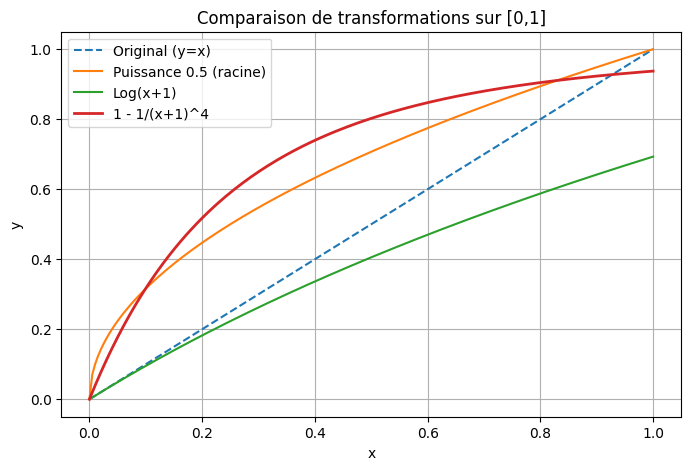

In [18]:
# Données entre 0 et 1
x = np.linspace(0, 1, 200)

# Transformations
t_original = x
t_power = np.sqrt(x)                  # puissance < 1
t_log = np.log1p(x)                    # log(x+1)
t_custom = 1 - 1 / ((x + 1) ** 4)      # formule personnalisée

# Tracer
plt.figure(figsize=(8, 5))
plt.plot(x, t_original, label='Original (y=x)', linestyle='--')
plt.plot(x, t_power, label='Puissance 0.5 (racine)')
plt.plot(x, t_log, label='Log(x+1)')
plt.plot(x, t_custom, label='1 - 1/(x+1)^4', linewidth=2)

plt.title("Comparaison de transformations sur [0,1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
youtube['insult_words_mean_treated'] = 1- 1/((youtube['insult_words_mean']+1)**4)

In [20]:
px.histogram(youtube['insult_words_mean_treated'], nbins = 25)

In [21]:
def reverse_transf_puiss(y, n):
    xb =  (1/(1-y)**(1/n))-1
    return xb

def reverse_transf_log(y):
    xb =  np.exp(y)-1
    return xb

In [22]:
#test
x=0.4

y = 1- 1/((x+1)**4)
print(reverse_transf_puiss(y, 4))

y = np.log(x+1)
print(reverse_transf_log(y))

0.3999999999999997
0.3999999999999999


# Correlation

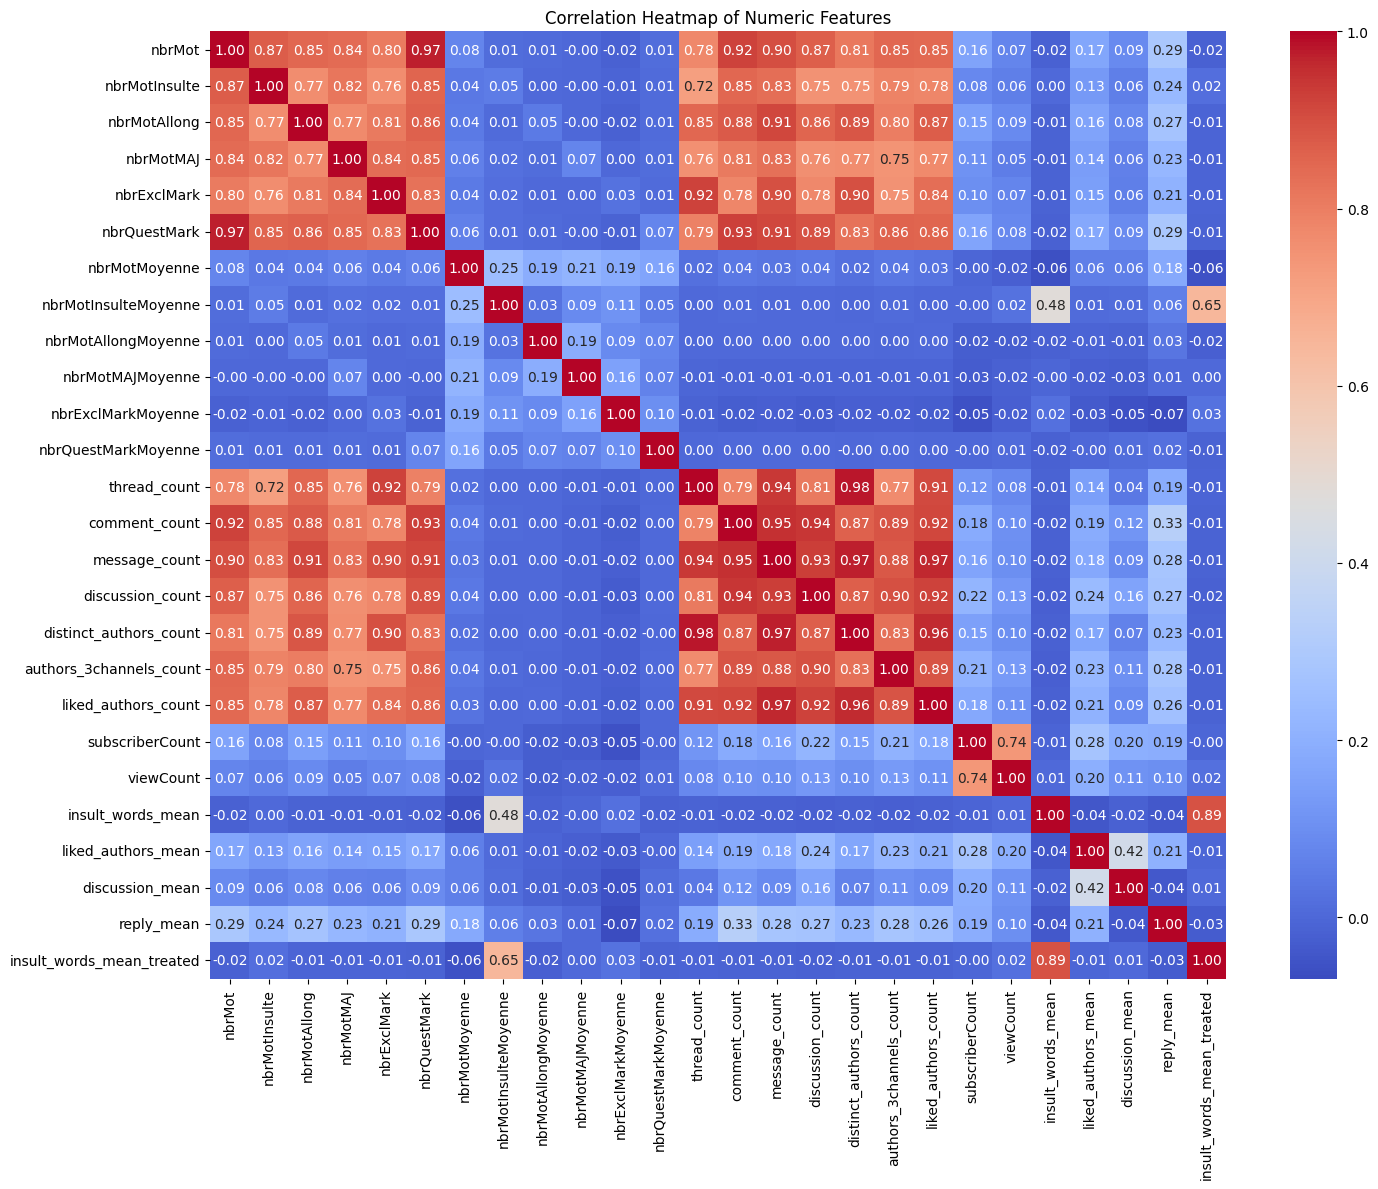

In [23]:
youtube_numeric = youtube.select_dtypes(include='number')
plt.figure(figsize=(15, 12))
sns.heatmap(youtube_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")

plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

All variables ending in nbrMot and _count are highly correlated. The more comments a video has, the more words, exclamation marks, and question marks it tends to accumulate.  
To reduce redundancy and simplify the analysis, we'll now focus on the mean-based variables.

In [24]:
youtube[['insult_words_mean','nbrMotMAJMoyenne', 'nbrMotAllongMoyenne', 'nbrQuestMarkMoyenne', 'nbrExclMarkMoyenne', 'subscriberCount', 'viewCount', 'liked_authors_mean', 'discussion_mean', 'reply_mean']].corr()['insult_words_mean']

insult_words_mean      1.000000
nbrMotMAJMoyenne      -0.004871
nbrMotAllongMoyenne   -0.015571
nbrQuestMarkMoyenne   -0.015915
nbrExclMarkMoyenne     0.019722
subscriberCount       -0.010591
viewCount              0.005407
liked_authors_mean    -0.042197
discussion_mean       -0.017163
reply_mean            -0.036455
Name: insult_words_mean, dtype: float64

<hr>

SubscriberCount and ViewCount are positively correlated, which is expected — popular channels generally attract more views.
However, a video's popularity does not seem to influence the level of verbal aggression in the comments section.

In contrast, nbrMotInsulteMoyenne is positively correlated with nbrExclMarkMoyenne.
This suggests that this feature could be a useful predictor when modeling or explaining the presence of insults in comments.

Finally, liked_authors_mean is negatively correlated, indicating that the more positively a video is perceived by authors in the comment section, the fewer insult words it tends to accumulate.

# Data preprocessing

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
#Check if values are missing 
youtube.isna().sum()

video_id_court                   0
video_id                         0
channel_id                       0
nbrMot                           0
nbrMotInsulte                    0
nbrMotAllong                     0
nbrMotMAJ                        0
nbrExclMark                      0
nbrQuestMark                     0
nbrMotMoyenne                    0
nbrMotInsulteMoyenne             0
nbrMotAllongMoyenne              0
nbrMotMAJMoyenne                 0
nbrExclMarkMoyenne               0
nbrQuestMarkMoyenne              0
thread_count                     0
comment_count                    0
message_count                    0
discussion_count                 0
distinct_authors_count           0
authors_3channels_count          0
liked_authors_count              0
channel_name                     0
subscriberCount                  0
viewCount                        0
categorie_new                    0
insult_words_mean               18
liked_authors_mean               0
discussion_mean     

In [27]:
youtube['nbrMotInsulte']

0         18
1          2
2         68
3          0
4          3
        ... 
46097      0
46098      1
46099      2
46100      0
46101    152
Name: nbrMotInsulte, Length: 46101, dtype: int64

In [28]:
youtube['nbrMotInsulteMoyenne']*youtube['message_count']

0         17.999995
1          2.000000
2         67.999997
3          0.000000
4          3.000000
            ...    
46097      0.000000
46098      1.000000
46099      2.000000
46100      0.000000
46101    152.000030
Length: 46101, dtype: float64

In [29]:
# Drop nbrMot <= 40
df = youtube.drop(youtube[youtube['nbrMot']<=40].index) #Insult_words_mean is a proportion, so it is more stable with some data
df = df.fillna(0)
df = df.reset_index(drop=True)

target = df['insult_words_mean']
# Let's drop every variable giving information on the channel as specified in the problem statement
df = df.drop(['nbrMotInsulte', 'video_id', 'video_id_court', 'channel_id', 'nbrMotInsulteMoyenne', 'authors_3channels_count', 'channel_name', 'subscriberCount', 'categorie_new', 'insult_words_mean', 'insult_words_mean_treated'], axis=1)

In [30]:
df.shape

(27868, 20)

In [31]:
px.histogram(target)

Let's define train_test functions. As some models need scaled data, we need 2 functions.

In [32]:
def get_train_test_set(df_, target_):
    x_train, x_test, y_train, y_test = train_test_split(df_,target_, test_size=0.2, random_state=5)
    numerical = x_train._get_numeric_data()
    categorical = list(set(x_train.columns)-set(numerical.columns))

    x_train = x_train.drop(categorical, axis=1)
    x_test = x_test.drop(categorical, axis=1)
    print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
    return x_train, x_test, y_train, y_test

In [33]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)


In [34]:
def get_scaled_train_test_set(df_, target_, is_y_class=False):
    x_train, x_test, y_train, y_test = get_train_test_set(df_, target_)

    sc_x_train = StandardScaler()
    x_train_scaled = sc_x_train.fit_transform(x_train.values)
    x_test_scaled = sc_x_train.transform(x_test.values)

    x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
    x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

    if not is_y_class:
        sc_y_train = StandardScaler()
        y_train_scaled = sc_y_train.fit_transform(y_train.values.reshape(-1,1))
        y_test_scaled = sc_y_train.transform(y_test.values.reshape(-1,1))
    else:
        y_train_scaled = y_train
        y_test_scaled = y_test
        sc_y_train=None
    return x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, sc_y_train

# SVR

In [35]:
from sklearn import svm
from sklearn.metrics import r2_score

The code below enables us to perform a __grid search__ and to get the optimal set of hyperparameters for the SVM, which minimizes the training error. However, Support Vector Regression (and SVM in general) are known to scale badly with the number of individuals in the dataset. The hyperparameters considered are :
- The kernel transformation applied to the SVR input, linear or RBF (Radial Basis Function for non linear relationships).
- The C coefficient : A regularization parameter controlling the trade-off between a wide margin and training errors. A larger C attempts to minimize errors, potentially overfitting..
- Gamma coeffcient for the 'rbf' kernel. Gamma defines the influence of individuals. A small gamma means a wide influence (smoother decision boundaries), while a large gamma leads to a more complex model that captures fine patterns but risks overfitting.

In [36]:
x_train, x_test, y_train, y_test, sc = get_scaled_train_test_set(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)


In [37]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def test_best_parameters_svr(x_train, y_train):
  parameters = {'kernel':['linear', 'rbf'], #rbf overfit easily, we could also try 'linear'
                'C':[1, 2, 4, 6], #the bigger C the bigger the risk of overfitting -> penalise the errors, we try on log scale C *10
                'gamma': ['auto','scale'],
                'epsilon':[0.3, 0.4, 0.5, 0.6, 0.7] #increase the marge tolerance (should be at the same scale as our data)
                }

  #gamma scale = 1/(n_features * X.var().mean())
  #gamma auto = 1/n_features

  svr = svm.SVR()

  clf = GridSearchCV(estimator=svr, 
                    param_grid=parameters,
                    cv=3, verbose=2, n_jobs=-1) #n_jobs=-1 allows parallel computation

  #Let's train only on 10% of our data to find the best combinason
  frac = 0.1
  n_samples = int(len(x_train) * frac)
  indices = np.random.choice(len(x_train), size=n_samples, replace=False) 

  X_sub = x_train.iloc[indices]
  y_sub = y_train[indices]
  clf.fit(X_sub, y_sub)
  print(clf.best_params_)
  return clf.best_params_

In [38]:
best_parameters = test_best_parameters_svr(x_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
{'C': 4, 'epsilon': 0.6, 'gamma': 'scale', 'kernel': 'rbf'}


c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



With 100% of the data, it takes 52 minutes to find the best parameters. This method is computationally expensive. So we trained only on 10% of the data with a lot of regularization. 

In [39]:
def train_model_svr(x_train, x_test, y_train, y_test, params, frac=0.5):
    clf = svm.SVR(**params) #As we use linear kernel, gamma is ignored
    n_samples = int(len(x_train) * frac)
    indices = np.random.choice(len(x_train), size=n_samples, replace=False) 

    X_sub = x_train.iloc[indices]
    y_sub = y_train[indices]
    clf.fit(X_sub, y_sub)

    r2_train = clf.score(X_sub, y_sub)
    r2_test = clf.score(x_test, y_test) #R2

    return clf, r2_train, r2_test

In [40]:
clf, r2_train, r2_test = train_model_svr(x_train, x_test, y_train, y_test, params=best_parameters)

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [41]:
print(r2_train, r2_test)

0.01997887363171058 0.005631287471941637


In [42]:
def auto_SVR(df, target):
    x_train, x_test, y_train, y_test, sc = get_scaled_train_test_set(df, target)
    best_parameters = test_best_parameters_svr(x_train, y_train)
    model, r2_train, r2_test = train_model_svr(x_train, x_test, y_train, y_test, params=best_parameters)
    pred = model.predict(x_test)
    pred = pred.reshape(-1,1)
    pred_unscaled = sc.inverse_transform(pred)
    print(f"Best model has r2_train : {r2_train}, and r2_test: {r2_test}")
    return model, r2_train, r2_test, pred_unscaled

In [43]:
model, r2_train, r2_test, pred_unscaled = auto_SVR(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)
Fitting 3 folds for each of 80 candidates, totalling 240 fits


c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'C': 1, 'epsilon': 0.6, 'gamma': 'scale', 'kernel': 'rbf'}
Best model has r2_train : 0.009962617389514983, and r2_test: 0.00551981162816384


# KNN

KNN relies on distance computations. To ensure that variables are comparable, we will remove the "count" variables and keep only the "mean" variables.
We will then apply a StandardScaler so that all variables are standardized and contribute equally to the distance metric.

In [44]:
df_mean = df.drop(['nbrMot', 'nbrMotAllong', 'nbrMotMAJ', 'nbrExclMark', 'nbrQuestMark', 'thread_count', 'comment_count', 'message_count', 'discussion_count', 'distinct_authors_count', 'liked_authors_count', 'viewCount'], axis=1)

In [45]:
x_train, x_test, y_train, y_test, sc = get_scaled_train_test_set(df_mean, target)

(22294, 8) (5574, 8) (22294,) (5574,)


In [46]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

Let's train the model on different value of k, in order to find the best parameters.

In [47]:
def test_best_parameters_knn(x_train, x_test, y_train, y_test):
    scores_train = []
    scores_test = []
    models = []
    
    best_score=-float("inf")
    no_improve_count=0
    for i in range(50,1000,50):
        KNNmodel = KNeighborsRegressor(n_neighbors = i)
        
        KNNmodel.fit(x_train,y_train[:,0])
        
        sc_train = KNNmodel.score(x_train, y_train[:,0])
        sc_test = KNNmodel.score(x_test, y_test[:,0])
        scores_train.append(sc_train)
        scores_test.append(sc_test)
        models.append(KNNmodel)
        if sc_train>best_score:
            best_score = sc_train
            no_improve_count=0
        else:
            no_improve_count+=1

        if no_improve_count>=5:
            break
        print("Score for",i,"neighbors :", sc_train)
    return models, scores_train, scores_test

In [48]:
models, scores_train, scores_test = test_best_parameters_knn(x_train, x_test, y_train, y_test)

Score for 50 neighbors : 0.053665597526225906
Score for 100 neighbors : 0.043057606807238025
Score for 150 neighbors : 0.03751338475930932
Score for 200 neighbors : 0.035105063761963984
Score for 250 neighbors : 0.033173298900728176


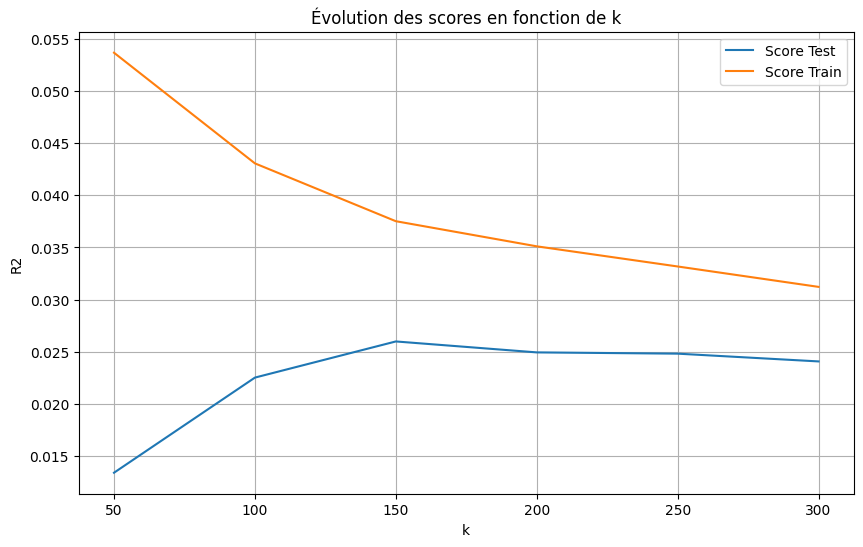

In [49]:
k_values = [(x+1)*50 for x in range(len(scores_train))]
plt.figure(figsize=(10,6))
plt.plot(k_values, scores_test, label='Score Test')
plt.plot(k_values, scores_train, label='Score Train')
plt.xlabel('k')  # ou autre axe x pertinent
plt.ylabel('R2')
plt.title('Évolution des scores en fonction de k')
plt.legend()
plt.grid(True)
plt.show()

k=150 seems to be the best parameter, with a R2 of 0.026, which is very low.

In [50]:
def get_best_model(models, scores_train, scores_test):
    best_score_train = np.array(scores_train).max()
    index = np.array(scores_train).argmax()
    score_test = scores_test[index]
    best_k = (index+1)*50
    best_model = models[index]
    return best_model, best_k, best_score_train, score_test


In [51]:
best_model, best_k, score_train, best_score_test = get_best_model(models, scores_train, scores_test)
print(best_k, score_train, best_score_test)

50 0.053665597526225906 0.013400561342967965


In [52]:
def auto_KNN(df, target):
    df_mean = df.drop(['nbrMot', 'nbrMotAllong', 'nbrMotMAJ', 'nbrExclMark', 'nbrQuestMark', 'thread_count', 'comment_count', 'message_count', 'discussion_count', 'distinct_authors_count', 'liked_authors_count', 'viewCount'], axis=1)
    x_train, x_test, y_train, y_test, sc = get_scaled_train_test_set(df_mean, target)
    models, scores_train, scores_test = test_best_parameters_knn(x_train, x_test, y_train, y_test)
    best_model, best_k, score_train, best_score_test = get_best_model(models, scores_train, scores_test)
    print(f"Best model found for k={best_k}. Score : {best_score_test}")
    pred = best_model.predict(x_test)
    pred = pred.reshape(-1,1)
    pred_unscaled = sc.inverse_transform(pred)
    return best_model, score_train, best_score_test, pred_unscaled

In [53]:
best_model, score_train, best_score_test, pred_unscaled = auto_KNN(df, target)

(22294, 8) (5574, 8) (22294,) (5574,)
Score for 50 neighbors : 0.053665597526225906
Score for 100 neighbors : 0.043057606807238025
Score for 150 neighbors : 0.03751338475930932
Score for 200 neighbors : 0.035105063761963984
Score for 250 neighbors : 0.033173298900728176
Best model found for k=50. Score : 0.013400561342967965


# Regression Tree

In [54]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [55]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target) #Regression Tree doens't need scaled data.

(22294, 20) (5574, 20) (22294,) (5574,)


As for SVR we are using a __grid search__ to get the optimal set of hyperparameters. The hyperparameters considered are :
- The size of the regressionTree, a bigger tree, means higher chance of overfitting.
- The min size of a leaf : its the minimum number of samples in a leaf (it helps the model generalize)

In [56]:
def test_best_parameters_rgr(x_train, y_train):
    rgr = tree.DecisionTreeRegressor()
    param_grid = {
        'max_depth':[None, 5, 10, 15, 20, 25, 30], 
        'min_samples_leaf':[16, 32, 64, 128, 256, 384, 516] #nb of samples min in each leaf
    }
    grid = GridSearchCV(estimator=rgr, param_grid=param_grid, cv=5)

    grid = grid.fit(x_train, y_train)
    print(grid.best_params_)
    return grid.best_params_

In [57]:
best_params = test_best_parameters_rgr(x_train, y_train)

{'max_depth': 25, 'min_samples_leaf': 384}


In [58]:
def train_model_rgr(x_train, x_test, y_train, y_test, params):
    rgr = tree.DecisionTreeRegressor(**params)
    rgr.fit(x_train, y_train)
    score_train = rgr.score(x_train, y_train)
    score_test = rgr.score(x_test, y_test)
    return rgr, score_train, score_test

In [59]:
model, score_train, score_test = train_model_rgr(x_train, x_test, y_train, y_test, params=best_params)

In [60]:
print(score_train)
print(score_test)

0.07435052316418478
0.05159325026580086


This model explains 5% of the variance, which is our best model so far. It is still low. 

In [61]:
def auto_rgr(df, target):
    x_train, x_test, y_train, y_test = get_train_test_set(df, target)
    best_params = test_best_parameters_rgr(x_train, y_train)
    model, score_train, score_test = train_model_rgr(x_train, x_test, y_train, y_test, params=best_params)
    pred_unscaled = model.predict(x_test)
    print(f"Best model has r2_train : {score_train}, and r2_test: {score_test}")
    return model, score_train, score_test, pred_unscaled

In [62]:
model, score_train, score_test, pred_unscaled = auto_rgr(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)
{'max_depth': 20, 'min_samples_leaf': 384}
Best model has r2_train : 0.07435052316418478, and r2_test: 0.05159325026580075


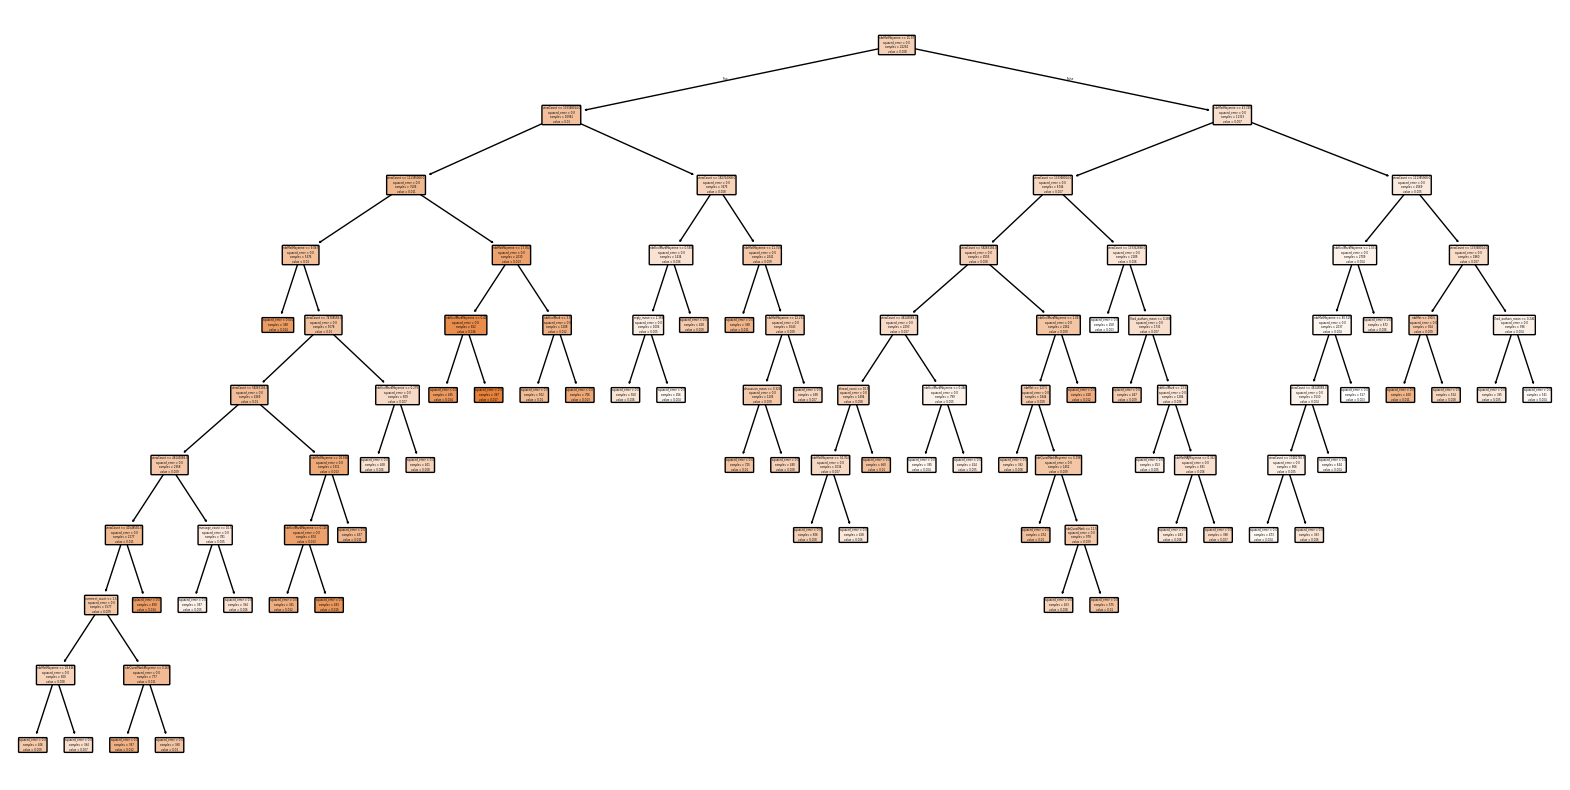

In [63]:
from sklearn.tree import plot_tree

features = list(x_train.columns)

plt.figure(figsize=(20,10))  # Ajuste la taille selon ton besoin
plot_tree(model, feature_names=features, filled=True, rounded=True)
plt.show()

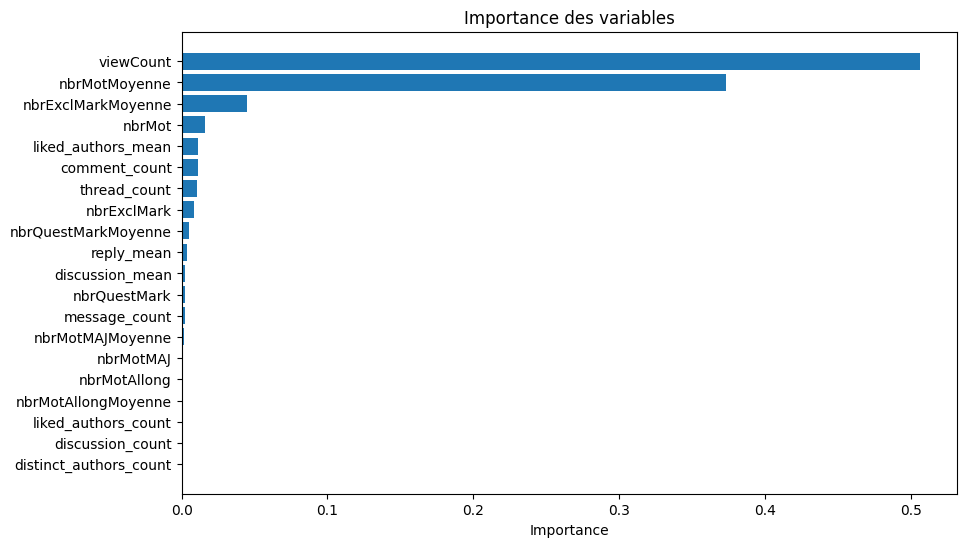

In [64]:
importances = model.feature_importances_
features = x_train.columns

feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Affichage graphique
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.title('Importance des variables')
plt.xlabel('Importance')
plt.show()

RegressionTree helps us understand the features the most important for our model. ViewCount and nbrMotMoyenne are the features with the most importance.

# Random Forest

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [66]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)


For the Random Forest the hyperparameters considered are :
- The number of trees.
- The size of the regressionTree, a bigger tree, means higher chance of overfitting.
- The min size of a leaf : its the minimum number of samples in a leaf (it helps the model generalize)

In [67]:
def test_best_parameters_rf(x_train, y_train):
    rf = RandomForestRegressor()
    grid_params = {
        'n_estimators':[50, 75, 100], 
        'max_depth':[6, 12, 18, 24],
        'min_samples_leaf':[32, 64, 128]
    }
    grid = GridSearchCV(estimator=rf, param_grid=grid_params, cv=3, n_jobs=-1)

    grid = grid.fit(x_train, y_train)
    print(grid.best_params_)
    return grid.best_params_

In [68]:
best_parameters = test_best_parameters_rf(x_train, y_train)

{'max_depth': 18, 'min_samples_leaf': 64, 'n_estimators': 100}


In [69]:
def train_model_rf(x_train, x_test, y_train, y_test, params):
    rf = RandomForestRegressor(**params)
    rf.fit(x_train, y_train)
    score_train = rf.score(x_train, y_train)
    score_test = rf.score(x_test, y_test)
    return rf, score_train, score_test

In [70]:
model, score_train, score_test = train_model_rf(x_train, x_test, y_train, y_test, best_parameters)

In [71]:
print(score_train)
print(score_test)

0.12960235246985863
0.06540529198665812


RandomForest is the best model so far. It explains 6.6% of the variance in our data.

In [72]:
def auto_rdf(df, target):
    x_train, x_test, y_train, y_test = get_train_test_set(df, target)
    best_parameters = test_best_parameters_rf(x_train, y_train)
    model, score_train, score_test = train_model_rf(x_train, x_test, y_train, y_test, best_parameters)
    pred = model.predict(x_test)
    print(f"Best model has r2_train : {r2_train}, and r2_test: {r2_test}")
    return model, score_train, score_test, pred

In [73]:
model, score_train, score_test, pred = auto_rdf(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)
{'max_depth': 18, 'min_samples_leaf': 64, 'n_estimators': 75}
Best model has r2_train : 0.009962617389514983, and r2_test: 0.00551981162816384


# Multi Layer Perceptron

In [74]:
import torch
import torch.nn as nn

In [75]:
x_train, x_test, y_train, y_test, sc = get_scaled_train_test_set(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)


As Multi Layer Perceptron overfits easily, we tried many solutions : 
- removing outliers in our data
- having more balanced batch
- L2 regularization

In [76]:
def remove_outliers_xy(x, y, multiplier=8):
    x = pd.DataFrame(x).copy()
    y = pd.Series(y.flatten(), index=x.index)

    mask = pd.Series([True] * len(x), index=x.index)

    for col in x.columns:
        Q1 = x[col].quantile(0.1)
        Q3 = x[col].quantile(0.9)
        IQR = Q3 - Q1
        
        col_mask = (x[col] >= (Q1 - multiplier * IQR)) & (x[col] <= (Q3 + multiplier * IQR))
        print(f"min : {Q1 - multiplier * IQR}, max : {Q3 + multiplier * IQR} for {col}. Number outliers : {x.shape[0] - col_mask.sum()}")
        mask &= col_mask

    Q1_y = y.quantile(0.1)
    Q3_y = y.quantile(0.9)
    IQR_y = Q3_y - Q1_y
    
    y_mask = (y >= (Q1_y - multiplier * IQR_y)) & (y <= (Q3_y + multiplier * IQR_y))
    print(f"min : {Q1_y - multiplier * IQR_y}, max : {Q3_y + multiplier * IQR_y} for target. Number of outliers : {x.shape[0] - y_mask.sum()}")
    final_mask = mask & y_mask

    print(f"% of outliers total: {(x.shape[0] - final_mask.sum())/x.shape[0]}")

    return x[final_mask].to_numpy(), y[final_mask].to_numpy()

In [77]:
x_train_, y_train_ = remove_outliers_xy(x_train, y_train)

min : -4.0057423771929646, max : 4.014812658924608 for nbrMot. Number outliers : 182
min : -3.8961031100945656, max : 3.887423807770918 for nbrMotAllong. Number outliers : 189
min : -3.604057200686407, max : 3.609379215019 for nbrMotMAJ. Number outliers : 175
min : -3.842608647185073, max : 3.8507140275598024 for nbrExclMark. Number outliers : 155
min : -4.39235660132121, max : 4.411219176193869 for nbrQuestMark. Number outliers : 167
min : -11.341145314806887, max : 11.436289736001182 for nbrMotMoyenne. Number outliers : 17
min : -4.634106767588157, max : 4.6674397186024414 for nbrMotAllongMoyenne. Number outliers : 87
min : -2.9014885914901734, max : 2.8394877470273263 for nbrMotMAJMoyenne. Number outliers : 169
min : -7.781711079650034, max : 7.831216572229446 for nbrExclMarkMoyenne. Number outliers : 39
min : -5.6051842837583905, max : 5.618054482098509 for nbrQuestMarkMoyenne. Number outliers : 33
min : -3.634877258083254, max : 3.627101838688044 for thread_count. Number outliers 

The __multi-layer perceptron__ is using relu activation.

In [78]:
class MLP(nn.Module):
    def __init__(self, input_size=20, num_layers=2, size_layer=64, dropout=0.25):
        super(MLP, self).__init__()

        layers = []
        in_size = input_size

        for i in range(num_layers):
            layers.append(nn.Linear(in_size, size_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_size = size_layer

        layers.append(nn.Linear(in_size, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [79]:
def create_weight_mask(y_train): #for balancing input data
    y_train = y_train.flatten()
    regularization = 10
    bins = pd.qcut(y_train, q=10, duplicates='drop')
    bin_counts = bins.value_counts()/y_train.shape[0]
    weights_dict = {interval: (1.0 / freq) + regularization for interval, freq in bin_counts.items()}
    weights = pd.Series(bins).map(weights_dict).astype(float).values
    weights_mean = weights.mean()
    weights = weights/weights_mean
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
    return weights_tensor

In [80]:
weights_tensor = create_weight_mask(y_train)
print(weights_tensor.min())
print(weights_tensor.max())
print(weights_tensor.mean())

tensor(0.7353)
tensor(1.1768)
tensor(1.)


In [81]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class IndexedTensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx

In [82]:
import torch.nn.functional as F

def train_model_nnet(x_train, x_test, y_train, y_test, params, weights_tensor=None, l2_reg=False):
    epochs = 200 # number of epochs
    losses = [] # list to stock the loss at each iteration
    losses_test = []
    losses_train = []

    if isinstance(x_train, pd.DataFrame):
        x_train = x_train.to_numpy()
        x_test = x_test.to_numpy()
    print(type(x_train), type(y_train), type(x_test),type(y_test))
    x_train_tensor = torch.Tensor(x_train.astype(np.float32))
    y_train_tensor = torch.Tensor(y_train.astype(np.float32))
    x_test_tensor = torch.Tensor(x_test.astype(np.float32))
    y_test_tensor = torch.Tensor(y_test.astype(np.float32))

    batch_size = 128
    net = MLP(**params)
    criterion = torch.nn.MSELoss(reduction='none')
    if l2_reg:
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4) #weight_decay is the L2 regularization parameter
    else: optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.75) #we divide by 2 the learning_rate if the model is stabilised

    dataset = IndexedTensorDataset(x_train_tensor, y_train_tensor)
    if weights_tensor is not None:
        sampler = WeightedRandomSampler(weights_tensor, num_samples=len(weights_tensor), replacement=True)
        dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = 0

    # Loop on epochs
    patience_counter = 0
    for epoch in range(epochs):
        start = time.time()
        net.train() #training mode with dropout
        for xb, yb, idx in dataloader: #x_batch, y_batch
            y_pred = net(xb)
            loss = criterion(y_pred.flatten(), yb.flatten()).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        net.eval() #Let's eval the nnet (no dropout here)
        with torch.no_grad():
            y_test_pred = net(x_test_tensor)
            loss_val = F.mse_loss(y_test_pred.flatten(), y_test_tensor.flatten())

            y_train_pred = net(x_train_tensor)
            loss_val_train = F.mse_loss(y_train_pred.flatten(), y_train_tensor.flatten())

        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']
        if loss_val < best_val_loss:
            best_epoch = epoch
            best_val_loss = loss_val
            best_model_state = net.state_dict()
            patience_counter=0
        else:
            patience_counter+=1
        losses_test.append(loss_val.item())
        losses_train.append(loss_val_train.item())
        end = time.time()
        print(f"Epoch {epoch+1} / {epochs}, loss on train: {loss_val_train}, time:{round(end-start,2)}s, loss_val : {loss_val}, learning_rate:{current_lr}")
        losses.append(loss.item())

        if patience_counter >=40:
            break
    
    net.eval()
    net.load_state_dict(best_model_state)
    y_test_pred = net(x_test_tensor)
    y_train_pred = net(x_train_tensor)
    r2_test = r2_score(y_test, y_test_pred.detach().numpy())
    r2_train = r2_score(y_train, y_train_pred.detach().numpy())
    
    return losses_test, losses_train, losses_test, net, r2_train, r2_test, best_epoch

In [83]:
x_train, x_test, y_train, y_test, sc = get_scaled_train_test_set(df, target)
params = {
    'input_size':df.shape[1], 
    'num_layers':3, 
    'size_layer':64, 
    'dropout':0.4
}
losses_test, losses_train, losses, model, r2_train, r2_test, best_epoch = train_model_nnet(x_train, x_test, y_train, y_test, params=params, l2_reg=False)

(22294, 20) (5574, 20) (22294,) (5574,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1 / 200, loss on train: 0.9864727854728699, time:0.35s, loss_val : 0.8828641772270203, learning_rate:0.001
Epoch 2 / 200, loss on train: 0.9715681672096252, time:0.32s, loss_val : 0.8679167032241821, learning_rate:0.001
Epoch 3 / 200, loss on train: 0.9652876853942871, time:0.33s, loss_val : 0.8621703386306763, learning_rate:0.001
Epoch 4 / 200, loss on train: 0.9615071415901184, time:0.31s, loss_val : 0.8584487438201904, learning_rate:0.001
Epoch 5 / 200, loss on train: 0.9608191251754761, time:0.31s, loss_val : 0.8565283417701721, learning_rate:0.001
Epoch 6 / 200, loss on train: 0.9603275656700134, time:0.35s, loss_val : 0.8558104038238525, learning_rate:0.001
Epoch 7 / 200, loss on train: 0.9583753943443298, time:0.32s, loss_val : 0.8568164706230164, learning_rate:0.001
Epoch 8 / 200, loss on train: 0.9580878019332886, time:0.32s, loss_val : 

In [84]:
print(r2_train)
print(r2_test)

0.06834699606980132
0.04446896005157264


Text(0.5, 1.0, 'Evolution of training set error with the number of epochs')

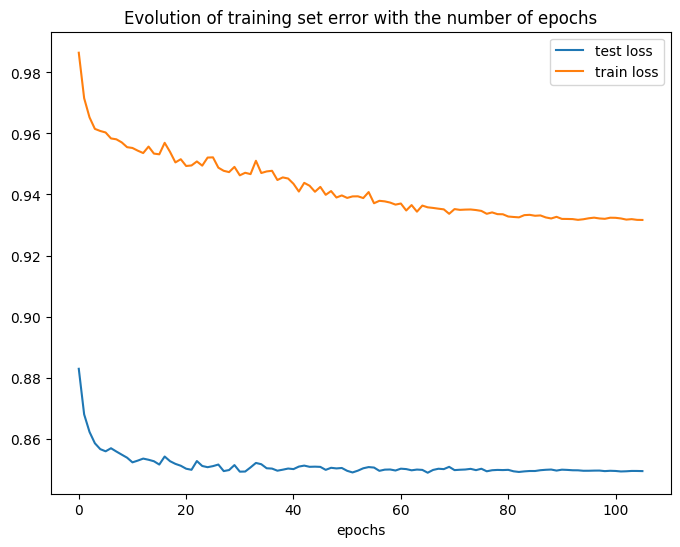

In [85]:
plt.figure(figsize=(8,6))
plt.plot(losses_test, label="test loss")
plt.plot(losses_train, label="train loss")
plt.xlabel('epochs')
plt.ylabel('')
plt.legend()
plt.title('Evolution of training set error with the number of epochs')

Even with a learning rate decreasing during the training, the loss is really unstable, on the test set

In [86]:
def auto_nnet(df, target, remove_outlier:bool=False, balanced:bool=False, l2_reg:bool=False):
    x_train, x_test, y_train, y_test, sc = get_scaled_train_test_set(df, target)

    x_train = x_train.to_numpy(dtype=np.float32)
    x_test = x_test.to_numpy(dtype=np.float32)
    # y_train = y_train.to_numpy(dtype=np.float32)
    # y_test = y_test.to_numpy(dtype=np.float32)

    if remove_outlier:
        x_train, y_train = remove_outliers_xy(x_train, y_train)
    if balanced:
        weights_tensor = create_weight_mask(y_train)
    else:
        weights_tensor=None

    params = {
        'input_size':df.shape[1], 
        'num_layers':3, 
        'size_layer':64, 
        'dropout':0.4
    }
    losses_test, losses_train, losses, model, r2_train, r2_test, best_epoch = train_model_nnet(x_train, x_test, y_train, y_test, weights_tensor=weights_tensor, l2_reg=l2_reg, params=params)
    print(f"Best model on epoch : {best_epoch}, with a r2 score : {r2_train} for the train and a r2 score : {r2_test} for the test set")
    
    x_test_tensor = torch.Tensor(x_test.astype(np.float32))
    pred = model(x_test_tensor)
    pred = pred.detach().numpy()
    pred_unscaled = sc.inverse_transform(pred)
    return model, r2_train, r2_test, pred_unscaled

In [87]:
model, r2_train, r2_test, pred_unscaled = auto_nnet(df, target, remove_outlier=True)

(22294, 20) (5574, 20) (22294,) (5574,)
min : -4.005742311477661, max : 4.014812588691711 for 0. Number outliers : 182
min : -3.896103113889694, max : 3.887423798441887 for 1. Number outliers : 189
min : -3.604057192802429, max : 3.609379217028618 for 2. Number outliers : 175
min : -3.842608705163002, max : 3.850714087486267 for 3. Number outliers : 155
min : -4.392356634140015, max : 4.411219209432602 for 4. Number outliers : 167
min : -11.341145277023315, max : 11.436289668083191 for 5. Number outliers : 17
min : -4.634106636047363, max : 4.667439579963684 for 6. Number outliers : 89
min : -2.901488497853279, max : 2.8394876569509506 for 7. Number outliers : 169
min : -7.781711012125015, max : 7.831216484308243 for 8. Number outliers : 39
min : -5.605184346437454, max : 5.618054538965225 for 9. Number outliers : 33
min : -3.634877234697342, max : 3.6271018236875534 for 10. Number outliers : 183
min : -4.655796468257904, max : 4.705922305583954 for 11. Number outliers : 162
min : -4.4

In [88]:
model, r2_train, r2_test, pred_unscaled = auto_nnet(df, target, balanced=True)

(22294, 20) (5574, 20) (22294,) (5574,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1 / 200, loss on train: 0.9932931065559387, time:0.32s, loss_val : 0.8968234658241272, learning_rate:0.001
Epoch 2 / 200, loss on train: 0.982208788394928, time:0.31s, loss_val : 0.8890310525894165, learning_rate:0.001
Epoch 3 / 200, loss on train: 0.9872545599937439, time:0.29s, loss_val : 0.8954055905342102, learning_rate:0.001
Epoch 4 / 200, loss on train: 0.9794551134109497, time:0.32s, loss_val : 0.8851315975189209, learning_rate:0.001
Epoch 5 / 200, loss on train: 0.9716346859931946, time:0.29s, loss_val : 0.8773632049560547, learning_rate:0.001
Epoch 6 / 200, loss on train: 0.9771478176116943, time:0.29s, loss_val : 0.8859257102012634, learning_rate:0.001
Epoch 7 / 200, loss on train: 0.9789299964904785, time:0.32s, loss_val : 0.8903181552886963, learning_rate:0.001
Epoch 8 / 200, loss on train: 0.9884302616119385, time:0.3s, loss_val : 0.

In [89]:
model, r2_train, r2_test, pred_unscaled = auto_nnet(df, target, l2_reg=True)

(22294, 20) (5574, 20) (22294,) (5574,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1 / 200, loss on train: 0.9803204536437988, time:0.41s, loss_val : 0.8724446296691895, learning_rate:0.001
Epoch 2 / 200, loss on train: 0.9712793231010437, time:0.33s, loss_val : 0.8645912408828735, learning_rate:0.001
Epoch 3 / 200, loss on train: 0.9642684459686279, time:0.34s, loss_val : 0.8621774911880493, learning_rate:0.001
Epoch 4 / 200, loss on train: 0.9625266790390015, time:0.37s, loss_val : 0.8606897592544556, learning_rate:0.001
Epoch 5 / 200, loss on train: 0.9598680734634399, time:0.34s, loss_val : 0.861290454864502, learning_rate:0.001
Epoch 6 / 200, loss on train: 0.9611953496932983, time:0.34s, loss_val : 0.856563925743103, learning_rate:0.001
Epoch 7 / 200, loss on train: 0.9590956568717957, time:0.39s, loss_val : 0.8558911681175232, learning_rate:0.001
Epoch 8 / 200, loss on train: 0.9597749710083008, time:0.33s, loss_val : 0.

In [90]:
model, r2_train, r2_test, pred_unscaled = auto_nnet(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1 / 200, loss on train: 0.9825922846794128, time:0.35s, loss_val : 0.8763630390167236, learning_rate:0.001
Epoch 2 / 200, loss on train: 0.9690467119216919, time:0.33s, loss_val : 0.8618491888046265, learning_rate:0.001
Epoch 3 / 200, loss on train: 0.961741030216217, time:0.33s, loss_val : 0.8586432933807373, learning_rate:0.001
Epoch 4 / 200, loss on train: 0.9633550047874451, time:0.33s, loss_val : 0.857890784740448, learning_rate:0.001
Epoch 5 / 200, loss on train: 0.9577339291572571, time:0.33s, loss_val : 0.8578728437423706, learning_rate:0.001
Epoch 6 / 200, loss on train: 0.9572910070419312, time:0.34s, loss_val : 0.8585742712020874, learning_rate:0.001
Epoch 7 / 200, loss on train: 0.9556330442428589, time:0.34s, loss_val : 0.8546010851860046, learning_rate:0.001
Epoch 8 / 200, loss on train: 0.9560688138008118, time:0.36s, loss_val : 0.

Getting balanced batch doesn't help the model as we get a lower R2. Removing outliers and L2_reg don't have significative impact on the model

In [91]:
px.histogram(pred_unscaled)

In [92]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target)
px.histogram(y_test)

(22294, 20) (5574, 20) (22294,) (5574,)


# Gradient boosting

XGBoost is a popular gradient boosting algorithm. Our analysis only concerns XGBoost and not other gradient boosting algorithms.

In [93]:
import xgboost as xgb

In [94]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)


In [95]:
def show_inportance(model):
    xgb.plot_importance(model, importance_type="weight")
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
# print(numerical.columns[1],numerical.columns[8], numerical.columns[0] )

In [96]:
from sklearn.model_selection import GridSearchCV, KFold
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def test_best_parameters_xgb(x_train, y_train):
    model = xgb.XGBRegressor()

    parameters = {'objective':['reg:squarederror'],
                'max_depth': [4, 6, 8],
                'subsample':[1], #% of data used for each step
                'min_child_weight' : [25, 50, 75, 100], #min nb of sample in a leaf
                'n_estimators': [200], #nb of tree
                'colsample_bytree':[0.8, 1], #% of columns used at each step
                'lambda':[1, 5, 7.5, 10], #L2 regularization
                # 'alpha':[0, 0.5], #L1 régularization
                # 'gamma': [0, 1], #minimum worth for a new node
                'learning_rate':[0.05, 0.1], #default=0.3
                'early_stopping_rounds':[50]
                } 

    cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

    xgb_grid = GridSearchCV(model,
                            parameters,
                            cv = cv_strategy,
                            n_jobs = 3,
                            verbose=True)
    

    frac = 0.2
    n_samples = int(len(x_train) * frac)
    indices = np.random.choice(len(x_train), size=n_samples, replace=False) 
    X_sub = x_train.iloc[indices]
    y_sub = y_train.iloc[indices]

    mask = ~x_train.index.isin(x_train.iloc[indices].index)
    X_rest = x_train.iloc[mask]
    y_rest = y_train.iloc[mask]
    
    xgb_grid.fit(X_rest, y_rest, eval_set=[(X_sub, y_sub)])
    print(xgb_grid.best_params_)
    return xgb_grid.best_params_

In [97]:
best_parameters = test_best_parameters_xgb(x_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[0]	validation_0-rmse:0.01315
[1]	validation_0-rmse:0.01313
[2]	validation_0-rmse:0.01310
[3]	validation_0-rmse:0.01308
[4]	validation_0-rmse:0.01306
[5]	validation_0-rmse:0.01304
[6]	validation_0-rmse:0.01303
[7]	validation_0-rmse:0.01301
[8]	validation_0-rmse:0.01300
[9]	validation_0-rmse:0.01298
[10]	validation_0-rmse:0.01297
[11]	validation_0-rmse:0.01296
[12]	validation_0-rmse:0.01295
[13]	validation_0-rmse:0.01294
[14]	validation_0-rmse:0.01293
[15]	validation_0-rmse:0.01292
[16]	validation_0-rmse:0.01291
[17]	validation_0-rmse:0.01290
[18]	validation_0-rmse:0.01290
[19]	validation_0-rmse:0.01289
[20]	validation_0-rmse:0.01289
[21]	validation_0-rmse:0.01288
[22]	validation_0-rmse:0.01288
[23]	validation_0-rmse:0.01287
[24]	validation_0-rmse:0.01287
[25]	validation_0-rmse:0.01287
[26]	validation_0-rmse:0.01286
[27]	validation_0-rmse:0.01286
[28]	validation_0-rmse:0.01285
[29]	validation_0-rmse:0.01285
[30]	validation_0

In [98]:
def train_model_xgb(x_train, x_test, y_train, y_test, params):
    model = xgb.XGBRegressor(**params)
    
    frac = 0.2
    n_samples = int(len(x_train) * frac)
    indices = np.random.choice(len(x_train), size=n_samples, replace=False) 
    X_sub = x_train.iloc[indices]
    y_sub = y_train.iloc[indices]

    mask = ~x_train.index.isin(x_train.iloc[indices].index)
    X_rest = x_train.iloc[mask]
    y_rest = y_train.iloc[mask]
    
    model.fit(X_rest, y_rest, eval_set=[(X_sub, y_sub)])
    r2_train = model.score(x_train, y_train)
    r2_test = model.score(x_test, y_test)
    return model, r2_train, r2_test

In [99]:
model, r2_train, r2_test = train_model_xgb(x_train, x_test, y_train, y_test, params=best_parameters)

[0]	validation_0-rmse:0.01288
[1]	validation_0-rmse:0.01286
[2]	validation_0-rmse:0.01283
[3]	validation_0-rmse:0.01281
[4]	validation_0-rmse:0.01279
[5]	validation_0-rmse:0.01277
[6]	validation_0-rmse:0.01275
[7]	validation_0-rmse:0.01273
[8]	validation_0-rmse:0.01272
[9]	validation_0-rmse:0.01270
[10]	validation_0-rmse:0.01269
[11]	validation_0-rmse:0.01268
[12]	validation_0-rmse:0.01267
[13]	validation_0-rmse:0.01266
[14]	validation_0-rmse:0.01265
[15]	validation_0-rmse:0.01264
[16]	validation_0-rmse:0.01263
[17]	validation_0-rmse:0.01262
[18]	validation_0-rmse:0.01262
[19]	validation_0-rmse:0.01261
[20]	validation_0-rmse:0.01260
[21]	validation_0-rmse:0.01259
[22]	validation_0-rmse:0.01258
[23]	validation_0-rmse:0.01258
[24]	validation_0-rmse:0.01257
[25]	validation_0-rmse:0.01257
[26]	validation_0-rmse:0.01256
[27]	validation_0-rmse:0.01256
[28]	validation_0-rmse:0.01255
[29]	validation_0-rmse:0.01255
[30]	validation_0-rmse:0.01255
[31]	validation_0-rmse:0.01254
[32]	validation_0-

In [100]:
print(r2_train)
print(r2_test)

0.09994729402753288
0.0652389008933536


As we see, xgb overfitted easily but it still get an r2 of 6.6% wich is the best r2 we could get from this dataset

In [101]:
def auto_xgb(df, target):
    x_train, x_test, y_train, y_test = get_train_test_set(df, target)
    best_parameters = test_best_parameters_xgb(x_train, y_train)
    model, r2_train, r2_test = train_model_xgb(x_train, x_test, y_train, y_test, params=best_parameters)
    pred = model.predict(x_test)
    print(f"Best model has r2_train : {r2_train}, and r2_test: {r2_test}")
    return model, r2_train, r2_test, pred

In [102]:
model, r2_train, r2_test, pred = auto_xgb(df, target)

(22294, 20) (5574, 20) (22294,) (5574,)
Fitting 3 folds for each of 192 candidates, totalling 576 fits
[0]	validation_0-rmse:0.01194
[1]	validation_0-rmse:0.01187
[2]	validation_0-rmse:0.01183
[3]	validation_0-rmse:0.01179
[4]	validation_0-rmse:0.01176
[5]	validation_0-rmse:0.01173
[6]	validation_0-rmse:0.01171
[7]	validation_0-rmse:0.01170
[8]	validation_0-rmse:0.01169
[9]	validation_0-rmse:0.01167
[10]	validation_0-rmse:0.01165
[11]	validation_0-rmse:0.01165
[12]	validation_0-rmse:0.01165
[13]	validation_0-rmse:0.01164
[14]	validation_0-rmse:0.01164
[15]	validation_0-rmse:0.01164
[16]	validation_0-rmse:0.01163
[17]	validation_0-rmse:0.01163
[18]	validation_0-rmse:0.01163
[19]	validation_0-rmse:0.01163
[20]	validation_0-rmse:0.01162
[21]	validation_0-rmse:0.01162
[22]	validation_0-rmse:0.01162
[23]	validation_0-rmse:0.01162
[24]	validation_0-rmse:0.01161
[25]	validation_0-rmse:0.01161
[26]	validation_0-rmse:0.01161
[27]	validation_0-rmse:0.01161
[28]	validation_0-rmse:0.01161
[29]	val

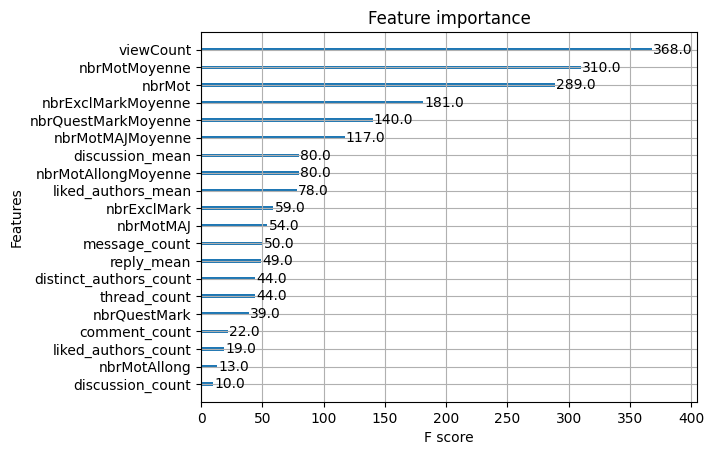

In [103]:
show_inportance(model)

# Comparison of the different regression methods

In [104]:
# Drop nbrMot <40
df = youtube.drop(youtube[youtube['nbrMot']<40].index)
df = df.fillna(0)
df = df.reset_index(drop=True)

df_target = df.copy()[['nbrMotInsulte', 'nbrMotInsulteMoyenne', 'insult_words_mean', "insult_words_mean_treated"]]
target_dict = {
    "nbrMotInsulte":df_target['nbrMotInsulte'],
    "nbrMotInsulteMoyenne":df_target['nbrMotInsulteMoyenne'],
    "insult_words_mean":df_target['insult_words_mean'],
    "insult_words_mean_treated":df_target["insult_words_mean_treated"]
}

# Let's drop every variable giving information on the channel as specified in the problem statement
df = df.drop(['nbrMotInsulte', 'video_id', 'video_id_court', 'channel_id', 'nbrMotInsulteMoyenne', 'authors_3channels_count', 'channel_name', 'subscriberCount', 'categorie_new', 'insult_words_mean', 'insult_words_mean_treated'], axis=1)

In [105]:
model_dict = {
    "SVR":auto_SVR,
    "KNN":auto_KNN,
    "RGR":auto_rgr,
    "RDF":auto_rdf,
    "XGB":auto_xgb,
    "NNET":auto_nnet,
    "NNET_rm_outliers":auto_nnet,
    "NNET_balanced":auto_nnet,
    "NNET_l2reg":auto_nnet
}

In [106]:
target_names = list(target_dict.keys())
target_list = list(target_dict.values())
model_names = list(model_dict.keys())
model_func = list(model_dict.values())
params_list = [{}, {}, {}, {}, {}, {}, {'remove_outlier':True}, {'balanced':True}, {'l2_reg':True}]

In [107]:
target_score_test = []
target_score_train = []
target_test_model = []
matrice_pred_unscaled = []
for target in target_list:
    models_score_test = []
    models_score_train = []
    models_test = []
    pred_unscaled_line = []
    for i, model in enumerate(model_func):
        params = params_list[i]
        md, score_train, score_test, pred_unscaled = model(df, target, **params)
        models_score_train.append(score_train)
        models_score_test.append(score_test)
        models_test.append(md)
        pred_unscaled_line.append(pred_unscaled)
    target_score_train.append(models_score_train)
    target_score_test.append(models_score_test)      
    target_test_model.append(models_test) 
    matrice_pred_unscaled.append(pred_unscaled_line)

(22476, 20) (5619, 20) (22476,) (5619,)
Fitting 3 folds for each of 80 candidates, totalling 240 fits


c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'C': 1, 'epsilon': 0.3, 'gamma': 'auto', 'kernel': 'linear'}
Best model has r2_train : 0.7115194571843395, and r2_test: 0.655154291349481
(22476, 8) (5619, 8) (22476,) (5619,)
Score for 50 neighbors : 0.18851512851267072
Score for 100 neighbors : 0.17277760169733603
Score for 150 neighbors : 0.1618175183981252
Score for 200 neighbors : 0.15483270184695552
Score for 250 neighbors : 0.15100113990482444
Best model found for k=50. Score : 0.2742815113384607
(22476, 20) (5619, 20) (22476,) (5619,)
{'max_depth': 10, 'min_samples_leaf': 16}
Best model has r2_train : 0.654459137774539, and r2_test: 0.7357004105213178
(22476, 20) (5619, 20) (22476,) (5619,)
{'max_depth': 6, 'min_samples_leaf': 32, 'n_estimators': 50}
Best model has r2_train : 0.11156857784690954, and r2_test: 0.05904902514933574
(22476, 20) (5619, 20) (22476,) (5619,)
Fitting 3 folds for each of 192 candidates, totalling 576 fits
[0]	validation_0-rmse:77.75399
[1]	validation_0-rmse:73.92419
[2]	validation_0-rmse:70.17080
[3]	v

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'C': 4, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}
Best model has r2_train : 0.1273486542348341, and r2_test: 0.052201405961167624
(22476, 8) (5619, 8) (22476,) (5619,)
Score for 50 neighbors : 0.10922215490462117
Score for 100 neighbors : 0.09824484104854858
Score for 150 neighbors : 0.09386622255649135
Score for 200 neighbors : 0.0888229301800284
Score for 250 neighbors : 0.0858470493696859
Best model found for k=50. Score : 0.06806164254483094
(22476, 20) (5619, 20) (22476,) (5619,)
{'max_depth': 5, 'min_samples_leaf': 32}
Best model has r2_train : 0.1551681109682287, and r2_test: 0.08142147826869583
(22476, 20) (5619, 20) (22476,) (5619,)
{'max_depth': 12, 'min_samples_leaf': 32, 'n_estimators': 100}
Best model has r2_train : 0.11156857784690954, and r2_test: 0.05904902514933574
(22476, 20) (5619, 20) (22476,) (5619,)
Fitting 3 folds for each of 192 candidates, totalling 576 fits
[0]	validation_0-rmse:0.47212
[1]	validation_0-rmse:0.46842
[2]	validation_0-rmse:0.46404
[3]	v

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'C': 2, 'epsilon': 0.6, 'gamma': 'scale', 'kernel': 'rbf'}
Best model has r2_train : 0.018346123405196813, and r2_test: 0.002061615493846647
(22476, 8) (5619, 8) (22476,) (5619,)
Score for 50 neighbors : 0.05685028507243928
Score for 100 neighbors : 0.044013404747321516
Score for 150 neighbors : 0.03938416218051366
Score for 200 neighbors : 0.03693523336999571
Score for 250 neighbors : 0.03451334574870757
Best model found for k=50. Score : 0.0034023192191938723
(22476, 20) (5619, 20) (22476,) (5619,)
{'max_depth': 30, 'min_samples_leaf': 256}
Best model has r2_train : 0.07939905690172122, and r2_test: 0.05702839935532833
(22476, 20) (5619, 20) (22476,) (5619,)
{'max_depth': 12, 'min_samples_leaf': 64, 'n_estimators': 100}
Best model has r2_train : 0.11156857784690954, and r2_test: 0.05904902514933574
(22476, 20) (5619, 20) (22476,) (5619,)
Fitting 3 folds for each of 192 candidates, totalling 576 fits
[0]	validation_0-rmse:0.01211
[1]	validation_0-rmse:0.01209
[2]	validation_0-rmse:0.

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\utilisateur\miniconda3\envs\data-science3.9\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'C': 4, 'epsilon': 0.7, 'gamma': 'auto', 'kernel': 'rbf'}
Best model has r2_train : 0.019758391689984056, and r2_test: 0.0032190678421821772
(22476, 8) (5619, 8) (22476,) (5619,)
Score for 50 neighbors : 0.05905606524503637
Score for 100 neighbors : 0.046162099496788955
Score for 150 neighbors : 0.041662469563508275
Score for 200 neighbors : 0.039111004769396884
Score for 250 neighbors : 0.03670754286185596
Best model found for k=50. Score : 0.006242974891078834
(22476, 20) (5619, 20) (22476,) (5619,)
{'max_depth': None, 'min_samples_leaf': 384}
Best model has r2_train : 0.07623750592129597, and r2_test: 0.06258963866379408
(22476, 20) (5619, 20) (22476,) (5619,)
{'max_depth': 24, 'min_samples_leaf': 64, 'n_estimators': 100}
Best model has r2_train : 0.11156857784690954, and r2_test: 0.05904902514933574
(22476, 20) (5619, 20) (22476,) (5619,)
Fitting 3 folds for each of 192 candidates, totalling 576 fits
[0]	validation_0-rmse:0.04383
[1]	validation_0-rmse:0.04375
[2]	validation_0-rmse

In [108]:
import joblib

In [109]:
#save_models
for i in range(len(target_test_model)):
    for j in range(len(target_test_model[0])):
        joblib.dump(target_test_model[i][j], f"models/{i}-{j}.joblib")

In [110]:
#load models
target_test_model = []
for i in range(len(target_list)):
    list_ = []
    for j in range(len(model_names)):
        list_.append(joblib.load(f"models/{i}-{j}.joblib"))
    target_test_model.append(list_)

In [111]:
import json

In [112]:
#save_scores
with open('output/target_score_train.json', 'w') as f:
    f.write(json.dumps(target_score_train))

with open('output/target_score_test.json', 'w') as f:
    f.write(json.dumps(target_score_test))

In [113]:
#load scores
with open('output/target_score_train.json', 'r') as f:
    target_score_train = json.load(f)

with open('output/target_score_test.json', 'r') as f:
    target_score_test = json.load(f)

In [114]:
#save unscaled pred
for i in range(len(target_test_model)):
    for j in range(len(target_test_model[0])):
        with open(f'output/{i}_{j}_unscaled_pred.json', 'w') as f:
            file = {
                "result":matrice_pred_unscaled[i][j].tolist()
            }
            f.write(json.dumps(file))

In [115]:
#load unscaled pred
matrice_pred_unscaled = []
for i in range(len(target_list)):
    list_ = []
    for j in range(len(model_names)):
        with open(f'output/{i}_{j}_unscaled_pred.json', 'r') as f:
            unscaled_data = json.load(f)
            unscaled_data = unscaled_data.get('result')
            list_.append(unscaled_data)
    matrice_pred_unscaled.append(list_)

In [116]:
import plotly.graph_objects as go

In [117]:
data = pd.DataFrame(
    target_score_test,
    columns=model_names,
    index=target_names
)

fig = go.Figure(data=go.Heatmap(
    z=data.values,
    x=data.columns,
    y=data.index,
    colorscale='Viridis'  # Ou 'Blues', 'Hot', etc.
))

fig.update_layout(title='R2 on test set')
fig.show()

As shown in the results, Random Forest achieves the highest performance for 'insult_words_mean_treated', 'insult_words_mean', and 'nbrMotInsulteMoyenne'.
For 'nbrMotInsulte', however, the NNET_classic model performs best, with an R2 score of 0.83.

When comparing the different NNET variants, performance differences are relatively small. Both NNET_balanced and NNET_rm_outliers consistently underperform compared to NNET_classic.
On the other hand, NNET_l2reg shows strong results for 'nbrMotInsulteMoyenne', slightly outperforming NNET_classic with an R2 score of 0.109 versus 0.105.

How can we explain the particularly high R2 for 'nbrMotInsulte' compared to other targets?
One possible explanation is that 'nbrMotInsulte' is highly correlated with nbrMot, whereas mean-based targets are inherently harder to predict.

In [118]:
data = pd.DataFrame(
    target_score_train,
    columns=model_names,
    index=target_names
)


fig = go.Figure(data=go.Heatmap(
    z=data.values,
    x=data.columns,
    y=data.index,
    colorscale='Viridis'  # Ou 'Blues', 'Hot', etc.
))

fig.update_layout(title='R2 on train set')
fig.show()

In [119]:
overfitting_matrice = np.array(target_score_train) - np.array(target_score_test)

In [120]:
data = pd.DataFrame(
    overfitting_matrice,
    columns=model_names,
    index=target_names
)


fig = go.Figure(data=go.Heatmap(
    z=data.values,
    x=data.columns,
    y=data.index,
    colorscale='Viridis'  # Ou 'Blues', 'Hot', etc.
))

fig.update_layout(title='Overfitting : diff R2 on train and test set')
fig.show()

To enable a fair comparison between models, we will transform all outputs to the same target representation. Specifically, we will convert 'nbrMotInsulte', 'nbrMotInsulteMoyenne', 'insult_words_mean_treated' into 'insult_words_mean'. 

In [121]:
def convert_nbrMotInsutle(df, output):    
    result = np.array(output)/df['nbrMot']
    return result

In [122]:
def convert_nbrMotInsulteMoyenne(df, output):
    result = np.array(output)/df['nbrMotMoyenne'] #mean of words in a comment
    return result

In [123]:
def convert_insult_words_mean_treated(df, output):
    result = reverse_transf_puiss(output, 4)
    return result

In [124]:
def does_nothing(df, output):
    return np.array(output)

In [125]:
def transform_data(func_list, matrice_pred_unscaled, df, y_test):
    result_list_all_models = []
    matrice_score = []
    for i, _ in enumerate(matrice_pred_unscaled):
        result_list_target = []
        list_r2 = []
        for j, data in enumerate(matrice_pred_unscaled[i]):
            data = np.array(data).flatten()
            data_converted = func_list[i](df=x_test, output=data)
            
            mask = ~np.isnan(data_converted)
            r2 = r2_score(y_test[mask], data_converted[mask])
            list_r2.append(r2)
            result_list_target.append(data_converted)
        result_list_all_models.append(result_list_target)
        matrice_score.append(list_r2)
    return matrice_score, result_list_all_models

In [126]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target_list[2])
func_list = [convert_nbrMotInsutle, convert_nbrMotInsulteMoyenne, does_nothing, convert_insult_words_mean_treated]
matrice_score, result_list_all_models = transform_data(func_list, matrice_pred_unscaled, df, y_test)

(22476, 20) (5619, 20) (22476,) (5619,)


In [127]:
matrice_score_positive = [row.copy() for row in matrice_score]
for i, line in enumerate(matrice_score_positive):
    for j, el in enumerate(line):
        if el < 0:
            matrice_score_positive[i][j]=0

For this graph we filtered r2_score values. We only show only models with r2_score > 0.

In [128]:
data = pd.DataFrame(
    matrice_score_positive,
    columns=model_names,
    index=target_names
)

fig = go.Figure(data=go.Heatmap(
    z=data.values,
    x=data.columns,
    y=data.index,
    colorscale='Viridis'  # Ou 'Blues', 'Hot', etc.
))

fig.update_layout(title='R2 Score on test set. Target = insult_words_mean')
fig.show()

Even though these models achieve relatively high R2 scores compared to models trained on other targets, when predictions are transformed to the same feature space, those trained on insult_words_mean and insult_words_mean_treated yield higher R2 values.

How to explain the bad performance of models trained on 'nbrMotInsulte' ? Models trained on nbrMotInsulte were not forced to scale with 'nbrMot' wich means 'nbrMotInsulte'/'nbrMot' has a strong variance. 
We should try the opposite, perform the reverse experiment by transforming all targets into nbrMotInsulte and comparing performance.

We investigated whether applying a non-linear transformation to the target variable to scale the feature even more improves the model’s predictive capacity. Based on our results, there is no evidence that such transformations systematically increase R2.

In [129]:
def lorrenz_curve(y_true, y_pred1, y_pred2, name1, name2):
    errors1 = np.abs(y_true - y_pred1)
    sorted_errors1 = np.sort(errors1)
    cum_errors1 = np.cumsum(sorted_errors1) / np.sum(sorted_errors1)
    population1 = np.arange(1, len(errors1)+1) / len(errors1)

    errors2 = np.abs(y_true - y_pred2)
    sorted_errors2 = np.sort(errors2)
    cum_errors2 = np.cumsum(sorted_errors2) / np.sum(sorted_errors2)
    population2 = np.arange(1, len(errors2)+1) / len(errors2)

    plt.plot(population1, cum_errors1, label=name1)
    plt.plot(population2, cum_errors2, label=name2)
    plt.plot([0,1], [0,1], '--', color='gray', label="Égalité parfaite")
    plt.xlabel("Fraction de la population")
    plt.ylabel("Fraction cumulée des erreurs")
    plt.legend()
    plt.show()

(22476, 20) (5619, 20) (22476,) (5619,)


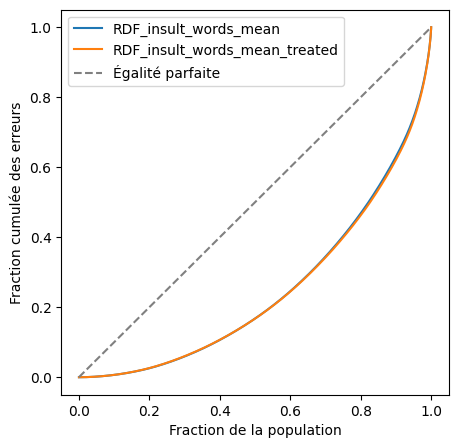

In [130]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target_list[2])
lorrenz_curve(y_test, result_list_all_models[2][3], result_list_all_models[3][3], 'RDF_insult_words_mean', 'RDF_insult_words_mean_treated')

In [131]:
def lorrenz_curve_modified(y_true, y_pred1, y_pred2, name1, name2):
    errors1 = np.abs(y_true - y_pred1)
    sorted_y_true = np.argsort(y_true)
    sorted_errors1 = errors1.iloc[sorted_y_true]
    cum_errors1 = np.cumsum(sorted_errors1) / np.sum(sorted_errors1)
    population1 = np.arange(1, len(errors1)+1) / len(errors1)

    errors2 = np.abs(y_true - y_pred2)
    sorted_errors2 = errors2.iloc[sorted_y_true]
    cum_errors2 = np.cumsum(sorted_errors2) / np.sum(sorted_errors2)
    population2 = np.arange(1, len(errors2)+1) / len(errors2)

    plt.plot(population1, cum_errors1, label=name1)
    plt.plot(population2, cum_errors2, label=name2)
    plt.plot([0,1], [0,1], '--', color='gray', label="Égalité parfaite")
    plt.xlabel("Fraction de la population")
    plt.ylabel("Fraction cumulée des erreurs")
    plt.legend()
    plt.show()

(22476, 20) (5619, 20) (22476,) (5619,)


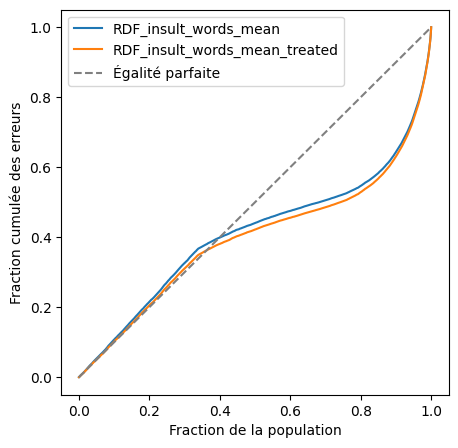

In [132]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target_list[2])
lorrenz_curve_modified(y_test, result_list_all_models[2][3], result_list_all_models[3][3], 'RDF_insult_words_mean', 'RDF_insult_words_mean_treated')

The two models exhibit similar behaviour, making low errors in the range [0.4,0.9]. Blue makes a bit more mistake in the range [0-0.3] in comparison. The transformation of the target has low impact, but it help the model in focusing in the low range of the feature.

In [133]:
def convert_nbrMotInsulteMoyenne(df, output):
    result = np.array(output)*df['message_count']
    return result

In [134]:
def convert_insult_words_mean_treated(df, output):
    result = reverse_transf_puiss(output, 4)*df['nbrMot']
    return result

In [135]:
def convert_insult_words_mean(df, output):
    result = output*df['nbrMot']
    return result

In [136]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target_list[0])
func_list = [does_nothing, convert_nbrMotInsulteMoyenne, convert_insult_words_mean, convert_insult_words_mean_treated]
matrice_score, result_list_all_models = transform_data(func_list, matrice_pred_unscaled, df, y_test)

(22476, 20) (5619, 20) (22476,) (5619,)


In [137]:
matrice_score_positive = [row.copy() for row in matrice_score]
for i, line in enumerate(matrice_score_positive):
    for j, el in enumerate(line):
        if el < 0:
            matrice_score_positive[i][j]=0

In [138]:
data = pd.DataFrame(
    matrice_score_positive,
    columns=model_names,
    index=target_names
)


fig = go.Figure(data=go.Heatmap(
    z=data.values,
    x=data.columns,
    y=data.index,
    colorscale='Viridis'  # Ou 'Blues', 'Hot', etc.
))

fig.update_layout(title='R2 Score on test set. Target = nbrMotInsulte')
fig.show()

As we see models trained on 'insult_words_mean_treated' and 'insult_words_mean' have also good performance with an r2_score > 0.8
Let's compare them using LorenzCurve

(22476, 20) (5619, 20) (22476,) (5619,)


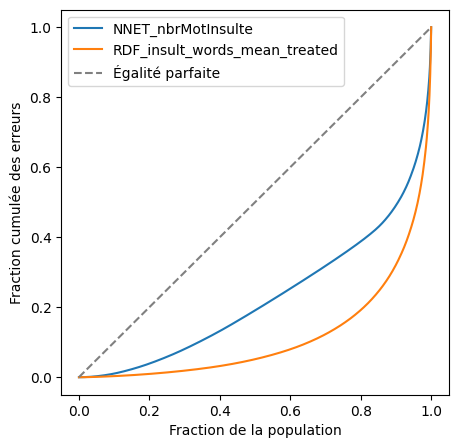

In [139]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target_list[0])
lorrenz_curve(y_test, result_list_all_models[0][5], result_list_all_models[3][3], 'NNET_nbrMotInsulte','RDF_insult_words_mean_treated')

(22476, 20) (5619, 20) (22476,) (5619,)


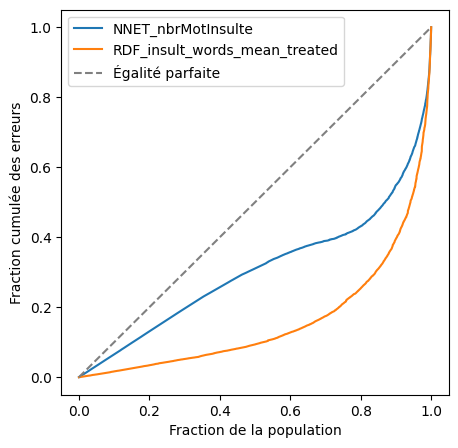

In [140]:
x_train, x_test, y_train, y_test = get_train_test_set(df, target_list[0])
lorrenz_curve_modified(y_test, result_list_all_models[0][5], result_list_all_models[3][3], 'NNET_nbrMotInsulte','RDF_insult_words_mean_treated')

Both models tend to perform worse for higher values of y. In NNET_nbrMotInsulte, prediction errors are more evenly distributed across the target range, meaning it produces a larger number of errors, but each tends to be of smaller magnitude. In contrast, RDF_insult_words_mean_treated produces fewer errors, but these are more concentrated and of higher magnitude. The error curve of RDF_insult_words_mean_treated show that the error is biased by 'nbrMot', but this bias is stable. 

## Conclusion

Although our targets are mathematically equivalent — predicting the mean value or the absolute count, given that the denominator feature is available, should in theory yield equivalent results — in practice, the models trained on these targets do not perform identically.

Training a model on the mean value constrains the target to a fixed scale [0,1], which standardizes the prediction space and reduces the variance of the output. This lower variance makes the learning problem more stable and allows the model to adapt more easily across different ranges of the denominator. Conversely, training on the raw count preserves the variability of both numerator and denominator, which can lead to amplified errors when converting to a mean, especially if the denominator has high variance. 

__Best model:__   
If the objective is to predict the absolute number of insult words in the comment section of a video, we recommend the NNET_nbrMotInsulte model, as it provides more evenly distributed errors and achieves an R2 of 81%.
If the objective is instead to estimate the proportion of insult words or if we need a more adaptative solution, the best choice is the RDF_insult_words_mean model, with an R2 of 6.6%.


We tested several approaches to improve the performance of our NNET models:

Removing outliers: No perceptible improvement; moreover, it risks biasing the model, as the test data may still contain outliers.
Balanced batches: No perceptible improvement; this can introduce bias by altering the distribution between the training and testing sets.
L2 regularization: Small positive impact, but limited in scope.

Overall, in this study, the most effective models were NNET and decision tree–based methods.

<hr>

# Toxicity score

In this part, we propose a new hand-made feature which we believe characterized the toxicity of a video. For this score we perform a PCA on variables that can define toxicity.  
Then, we will train a model to predict the new score. 

## PCA

In [143]:
df_reduc = youtube[youtube['nbrMotInsulte']<2000] #We get rid of outliers
df_reduc = df_reduc.drop(['channel_name', 'categorie_new']+['video_id', 'video_id_court', 'channel_id'], axis=1)
df_reduc = df_reduc.fillna(0)

ratio = 0.8

indices = list(np.arange(0,df_reduc.shape[0]))
np.random.shuffle(indices)
split = int(df_reduc.shape[0]*0.8)

After centering and reducing the values of the training set, we perform the PCA and decide how many principal components will be enough for describing the variance of the set.

In [144]:
from sklearn.decomposition import PCA

X = df_reduc.values
std = StandardScaler().fit(X)

X_scaled = std.transform(X)

pca = PCA().fit(X_scaled)
X_proj = pca.transform(X_scaled)

(26,)


Text(0, 0.5, 'Fraction of variance explained')

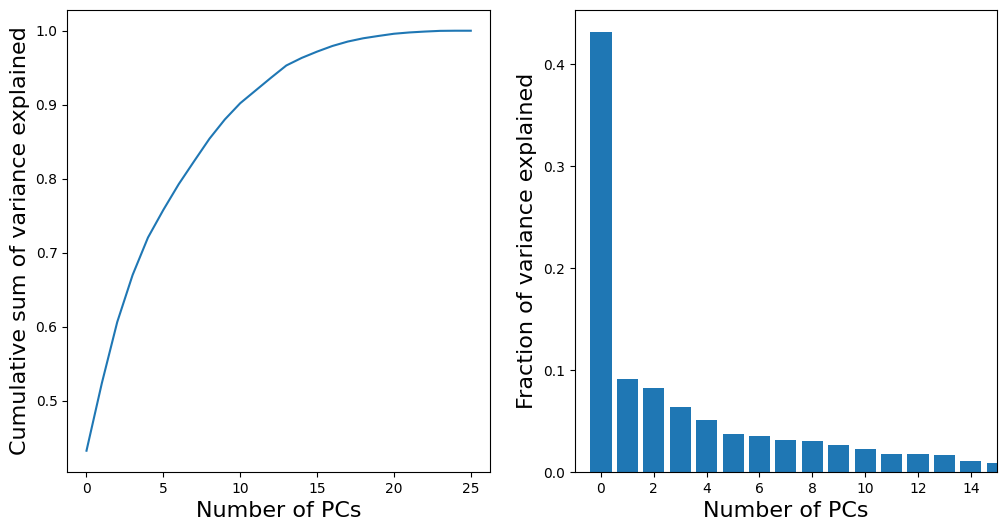

In [145]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_).shape)
ax1.set_xlabel("Number of PCs", fontsize=16)
ax1.set_ylabel("Cumulative sum of variance explained", fontsize=16)
ax2.bar(np.arange(X_proj.shape[1]), pca.explained_variance_ratio_)
ax2.axis(xmin=-1,xmax=15)
ax2.set_xlabel("Number of PCs", fontsize=16)
ax2.set_ylabel("Fraction of variance explained", fontsize=16)

Taking the __3 first PC__ may be enough. Each PC consists in a linear combination of variables (here we consider 15 of them). The linear combination weights will be used to compute the future hand-made score of toxicity. We also keep two components to make it simpler

In [146]:
cumul = np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumul)):
    print(i+1,'components :', cumul[i])

1 components : 0.43210366358001767
2 components : 0.5235635824131197
3 components : 0.6061284471139662
4 components : 0.6697120587990553
5 components : 0.720371959376557
6 components : 0.7577766718383485
7 components : 0.7925422428427384
8 components : 0.8235199692468106
9 components : 0.8539852858155744
10 components : 0.8800258994134613
11 components : 0.9019808541838252
12 components : 0.9191794948228521
13 components : 0.9363645563547501
14 components : 0.9530049457005595
15 components : 0.963240228366571
16 components : 0.9717556398165516
17 components : 0.9793938729839174
18 components : 0.9853661573042068
19 components : 0.9897774480853189
20 components : 0.992954469176253
21 components : 0.9959070476040109
22 components : 0.997657710687892
23 components : 0.9988575010317419
24 components : 0.9998047520679813
25 components : 0.9999999999999999
26 components : 0.9999999999999999


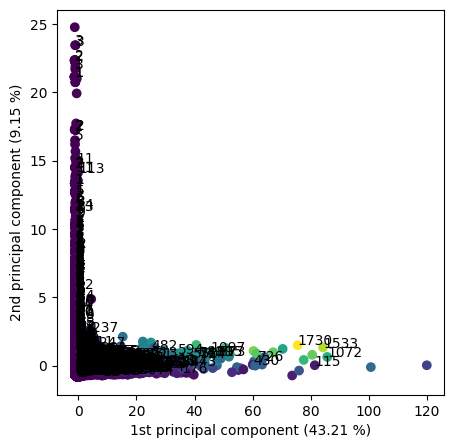

In [147]:
plt.figure(figsize=(5,5))
plt.scatter(X_proj[:,0], X_proj[:,1], c=df_reduc['nbrMotInsulte'])
plt.xlabel('1st principal component (' + str(round(pca.explained_variance_ratio_[0]*100,2))+ ' %)')
plt.ylabel('2nd principal component (' + str(round(pca.explained_variance_ratio_[1]*100,2))+ ' %)')
# plt.xlim(-10, 100)
# plt.ylim(-5, 5)

for i in range(10000):
    plt.text(X_proj[i,0], X_proj[i,1], df_reduc['nbrMotInsulte'][i])

A high value on the first PC seems to be correlated with the number of InsultWords.  
A low value on the second PC seems to be correlated with the toxicity of the video.

Text(0, 0.5, '2nd principal component')

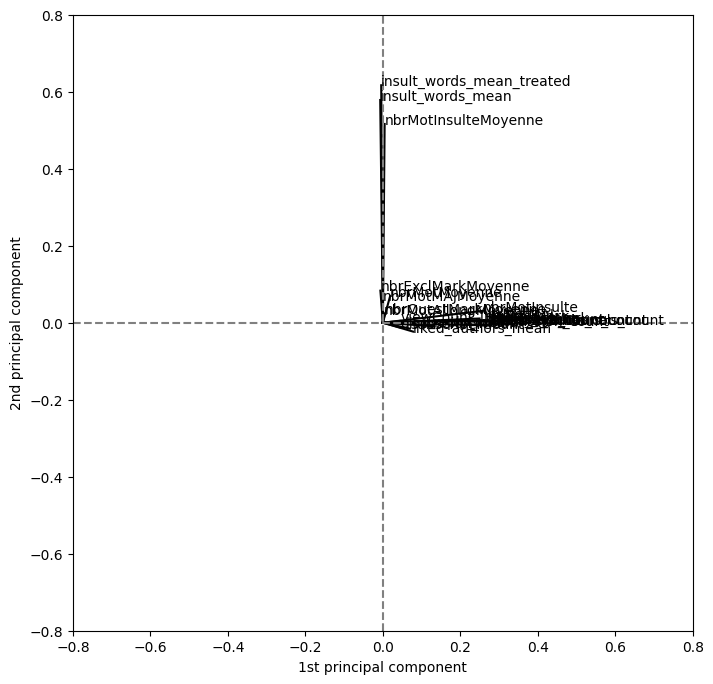

In [148]:
components = pca.components_
fig = plt.figure(figsize=(8, 8))
for i, (x, y) in enumerate(zip(components[0,:], components[1,:])):
    plt.plot([0, x], [0, y], color='k')
    plt.text(x, y, df_reduc.columns[i])

plt.plot([-0.8, 0.8], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-0.8, 0.8], color='grey', ls='--')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')

- The __first component__ seems to be correlated with all the variables related to the video comments (number of words, insults, top commments etc.)
- The __second component__ is correlated with the variables showing the popularity of the channel and so the media on Youtube (number of subscribers and views). It takes the nbrMotInsulteMoyenne, so it gives a clue on the toxicity of the video.

Text(0, 0.5, '3rd principal component')

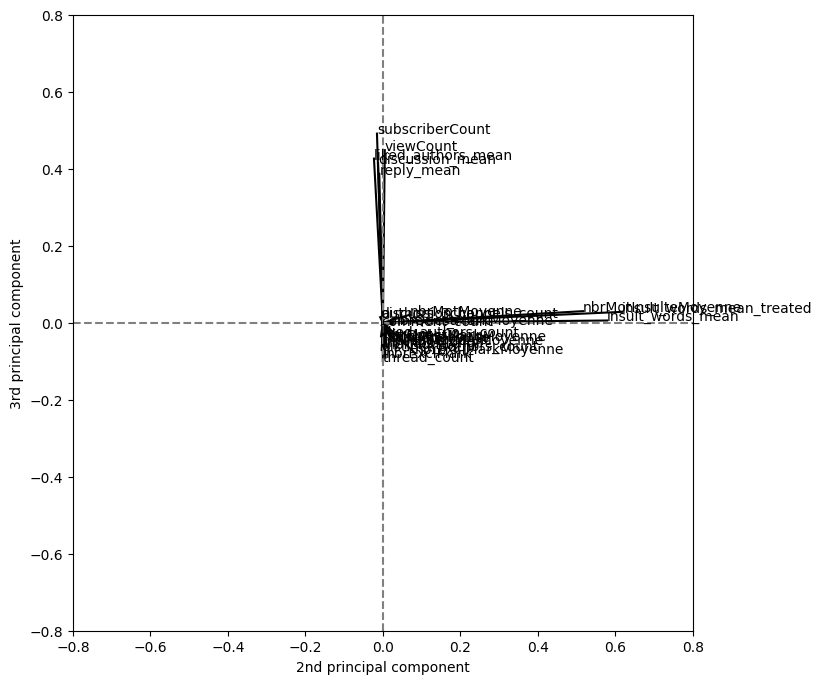

In [149]:
components = pca.components_
fig = plt.figure(figsize=(8, 8))
for i, (x, y) in enumerate(zip(components[1,:], components[2,:])):
    plt.plot([0, x], [0, y], color='k')
    plt.text(x, y, df_reduc.columns[i])

plt.plot([-0.8, 0.8], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-0.8, 0.8], color='grey', ls='--')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

plt.xlabel('2nd principal component')
plt.ylabel('3rd principal component')

__Remark__ : It is difficult to find any meaningful interpretation for the third component, as it is influenced by the same variables as the second principal component.

In [150]:
X_proj

array([[ 2.16656537e+00, -2.65225030e-01,  2.69719518e+00, ...,
         5.08099304e-02,  6.43457831e-02,  1.21679505e-13],
       [-9.21936245e-01,  2.90163162e+00, -3.57332513e-01, ...,
        -4.78816662e-03,  2.54131153e-03,  2.45544768e-15],
       [ 2.41099407e+00,  6.99075465e-01,  2.60535783e+00, ...,
         1.26564684e-01,  1.19946812e-01,  1.85575380e-13],
       ...,
       [-6.42799989e-01, -4.42214256e-02,  4.00627436e-01, ...,
        -1.15597113e-03, -9.26751245e-03, -1.30618333e-14],
       [-5.74034381e-01, -4.95098825e-01,  1.13092885e+00, ...,
         5.40948101e-03, -2.03123073e-03, -3.60618316e-15],
       [ 1.11761287e+01,  2.47120067e-02,  1.61673740e+00, ...,
         3.78007729e-01,  1.65389722e-01,  4.14838005e-13]])

In [151]:
PC1_proj = X_proj[:,0]
PC2_proj = X_proj[:,1]

col_pc1 = pd.Series(PC1_proj, name = 'PC_proj', index = df_reduc.index)
col_pc2 = pd.Series(PC2_proj, name = 'PC_proj', index = df_reduc.index)

# This is the new hand-made feature
col_mix = 0.7*col_pc1 - 0.3*col_pc2 #We want the first pc to have a bigger impact

# We transform the previous feature into a score with : 0 (not toxic), 1 (toxic), 2 (very toxic)
qn = np.quantile(col_mix, [0.7,0.9])
qn_split_1 = qn[0]
qn_split_2 = qn[1]

df_reduc_scored = pd.concat([df_reduc, col_mix], axis=1,ignore_index=False)

df_reduc_scored.loc[df_reduc_scored['PC_proj'] <= qn_split_2, 'Score'] = 1
df_reduc_scored.loc[df_reduc_scored['PC_proj'] > qn_split_2, 'Score'] = 2
df_reduc_scored.loc[df_reduc_scored['PC_proj'] <= qn_split_1, 'Score'] = 0

df_reduc_scored = df_reduc_scored.drop('PC_proj', axis=1)

In [152]:
df_reduc_scored['Score'].value_counts()

Score
0.0    32268
1.0     9219
2.0     4610
Name: count, dtype: int64

### Model training on the new score

We try a simple Logistic regression classifier to predict this new score.

In [153]:
x_df = df_reduc_scored.drop(['nbrMotInsulte', 'nbrMotInsulteMoyenne', 'Score'],axis=1)
y_df = df_reduc_scored['Score']
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=10)

In [154]:
y_test = y_test.astype(np.int64)
y_train = y_train.astype(np.int64)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [155]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='saga', multi_class='auto', max_iter=5000).fit(x_train, y_train)
preds = logit.predict(x_test)

In [156]:
from sklearn.metrics import confusion_matrix, f1_score

print(confusion_matrix(preds,y_test))

print(f1_score(preds,y_test,average=None))

[[6359   50    0]
 [  39 1834   19]
 [   0    3  916]]
[0.99305068 0.97062715 0.98813376]


The F1 score is very high. LogisticRegression is efficient in predicting the toxicity score.